In [1]:
%matplotlib inline
%reload_ext autoreload

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import seaborn as sns
import logging

FORMAT = "%(asctime)s %(message)s"

logging.basicConfig(level="INFO", format=FORMAT, datefmt="%d-%b-%y %H:%M:%S")
sns.set_context("talk")

In [3]:
epoch_key = 'Jaq', 3, 12

In [4]:
from dask.distributed import Client

# for virga
client = Client(n_workers=8, threads_per_worker=8, processes=True)

client

distributed.diskutils - INFO - Found stale lock file and directory '/stelmo/edeno/pose_analysis/notebooks/dask-worker-space/worker-2e60c6vt', purging


<Client: 'tcp://127.0.0.1:35881' processes=8 threads=64, memory=1.48 TiB>

In [5]:
from src.load_data import load_data


data = load_data(epoch_key,
                 position_to_linearize=['nose_x', 'nose_y'],
                 max_distance_from_well=30,
                 min_distance_traveled=50,
                 )

19-Dec-21 15:24:57 Loading position info...
19-Dec-21 15:25:49 Loading multiunit...
19-Dec-21 15:26:14 Loading spikes...
19-Dec-21 15:26:21 Finding ripple times...


In [8]:
import numpy as np

detector_parameters = {
    'movement_var': 6.0,
    'replay_speed': 1,
    'place_bin_size': 2.5,
    'spike_model_knot_spacing': 8.0,
    'spike_model_penalty': 0.5,
    'movement_state_transition_type': 'random_walk',
    'multiunit_model_kwargs': {
        'bandwidth': np.array([20.0, 20.0, 20.0, 20.0, 8.0])},
    'multiunit_occupancy_kwargs': {'bandwidth': np.array([8.0])},
    'discrete_state_transition_type': 'ripples_no_speed_threshold',
}

In [9]:
from replay_identification import ReplayDetector
from src.parameters import WTRACK_EDGE_ORDER, WTRACK_EDGE_SPACING

replay_detector = ReplayDetector(**detector_parameters)
logging.info(replay_detector)

19-Dec-21 15:31:35 ReplayDetector(discrete_diagonal=None,
               discrete_state_transition_type='ripples_no_speed_threshold',
               infer_track_interior=True, is_track_interior=None,
               lfp_model=<class 'sklearn.mixture._bayesian_mixture.BayesianGaussianMixture'>,
               lfp_model_kwargs={'max_iter': 200, 'n_components': 1,
                                 'tol': 1e-06},
               movement_state_transition_type='random_walk', movement_var=6.0,
               m...
               multiunit_model_kwargs={'bandwidth': array([20., 20., 20., 20.,  8.])},
               multiunit_occupancy_kwargs={'bandwidth': array([8.])},
               multiunit_occupancy_model=<class 'replay_identification.multiunit_likelihood.NumbaKDE'>,
               place_bin_size=2.5, position_range=None, replay_speed=1,
               replay_state_transition_penalty=1e-05, speed_knots=None,
               speed_threshold=4.0, spike_model_knot_spacing=8.0,
               spik

In [10]:
fit_args = dict(
    is_ripple=data['is_ripple'],
    is_training=~data['is_ripple'].values.squeeze(),
    speed=data['position_info'].nose_vel,
    position=data['position_info'].linear_position,
    spikes=data['spikes'],
    track_graph=data['track_graph'],
    edge_order=WTRACK_EDGE_ORDER,
    edge_spacing=WTRACK_EDGE_SPACING)

predict_args = dict(
    speed=data['position_info'].nose_vel,
    position=data['position_info'].linear_position,
    spikes=data['spikes'],
    time=data['position_info'].index / np.timedelta64(1, 's'),
    use_likelihoods=['spikes'],
    use_acausal=True,
    set_no_spike_to_equally_likely=False
)

In [11]:
replay_detector.fit(**fit_args)

19-Dec-21 15:32:05 Fitting speed model...
19-Dec-21 15:32:06 Fitting spiking model...
19-Dec-21 15:36:33 Fitting replay movement state transition...
19-Dec-21 15:36:34 Fitting replay state transition...


ReplayDetector(discrete_diagonal=None,
               discrete_state_transition_type='ripples_no_speed_threshold',
               infer_track_interior=True, is_track_interior=None,
               lfp_model=<class 'sklearn.mixture._bayesian_mixture.BayesianGaussianMixture'>,
               lfp_model_kwargs={'max_iter': 200, 'n_components': 1,
                                 'tol': 1e-06},
               movement_state_transition_type='random_walk', movement_var=6.0,
               m...
               multiunit_model_kwargs={'bandwidth': array([20., 20., 20., 20.,  8.])},
               multiunit_occupancy_kwargs={'bandwidth': array([8.])},
               multiunit_occupancy_model=<class 'replay_identification.multiunit_likelihood.NumbaKDE'>,
               place_bin_size=2.5, position_range=None, replay_speed=1,
               replay_state_transition_penalty=1e-05, speed_knots=None,
               speed_threshold=4.0, spike_model_knot_spacing=8.0,
               spike_model_penalty=0.5

In [12]:
results = replay_detector.predict(**predict_args)

19-Dec-21 15:36:34 Predicting spikes likelihood...


neurons:   0%|          | 0/121 [00:00<?, ?it/s]

neurons:   0%|          | 0/121 [00:00<?, ?it/s]

19-Dec-21 15:37:58 Finding causal non-local probability and position...
19-Dec-21 15:38:07 Finding acausal non-local probability and position...


In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
import copy

from scipy.stats import zscore


def plot_detector(time_ind, data, replay_detector, detector_results,
                  figsize=(11, 6.0)):
    fig, axes = plt.subplots(6, 1,
                             figsize=figsize,
                             sharex=True,
                             constrained_layout=True,
                             gridspec_kw={
                                 'height_ratios': [1, 1, 3, 1, 3, 1]},
                            dpi=100)
    time = data['spikes'].iloc[time_ind].index / np.timedelta64(1, 's')
    
    # axes 0
    # max_consensus = np.ceil(zscore(data['ripple_consensus_trace'], nan_policy='omit').values.max()).astype(int)
    start_time = data['spikes'].iloc[time_ind].index.min()
    end_time = data['spikes'].iloc[time_ind].index.max()
    ripple_consensus_trace = zscore(data['ripple_consensus_trace'], nan_policy='omit').loc[start_time:end_time]
    
    max_consensus = max(int(np.ceil(ripple_consensus_trace.max())), 5)
    min_consensus = min(int(np.ceil(ripple_consensus_trace.min())), -1)
    ripple_consensus_trace_time = ripple_consensus_trace.index / np.timedelta64(1, 's')
    
    axes[0].fill_between(
        time, np.ones_like(time) * max_consensus,
        where=data['ripple_labels'].iloc[time_ind].values.squeeze() > 0,
        color='red', zorder=-2, alpha=0.6, step='pre')
    axes[0].fill_between(
        ripple_consensus_trace_time,
        ripple_consensus_trace.values.squeeze(), color='black')
    axes[0].set_ylim((min_consensus, max_consensus))
    axes[0].set_yticks((min_consensus, max_consensus))
    axes[0].set_ylabel("Ripple\nSTd.")
    
    # axes 1
    multiunit_firing = (
        data["multiunit_firing_rate"]
        .reset_index(drop=True)
        .set_index(
            data["multiunit_firing_rate"].index / np.timedelta64(1, "s"))
    )
    max_multiunit = np.ceil(data["multiunit_firing_rate"].values.max()).astype(int)
    axes[1].fill_between(
        multiunit_firing.iloc[time_ind].index.values,
        multiunit_firing.iloc[time_ind].values.squeeze(),
        color="black",
    )
    axes[1].fill_between(
        time, np.ones_like(time) * max_multiunit,
        where=data["multiunit_high_synchrony_labels"].iloc[time_ind].values.squeeze() > 0,
        color='blue', zorder=-2, alpha=0.6, step='pre')
    axes[1].set_ylim((0, max_multiunit))
    axes[1].set_yticks((0, max_multiunit))
    axes[1].set_ylabel("Multiunit\nRate\n[spikes / s]")

    # axes 2
    place_fields = (
        replay_detector._spiking_likelihood
        .keywords['place_conditional_intensity']).squeeze()
    place_field_max = np.nanargmax(place_fields, axis=0)
    linear_position_order = place_field_max.argsort(axis=0).squeeze()
    spike_time_ind, neuron_ind = np.nonzero(
        np.asarray(data['spikes'].iloc[time_ind])[:, linear_position_order])

    axes[2].scatter(time[spike_time_ind], neuron_ind,
                    clip_on=False, s=10, color='black', marker='|', rasterized=True)
    axes[2].set_ylim((0, place_fields.shape[1]))
    axes[2].set_yticks((0, place_fields.shape[1]))
    axes[2].set_ylabel('Cells')
    axes[2].fill_between(
        time, np.ones_like(time) * place_fields.shape[1],
        where=detector_results.isel(time=time_ind).non_local_probability >= 0.80,
        color='green', zorder=-1, alpha=0.6, step='pre')
    
    # axes 3
    detector_results.isel(time=time_ind).non_local_probability.plot(
        x='time', ax=axes[3], color='black', clip_on=False)
    axes[3].set_ylabel('Prob.')
    axes[3].set_xlabel("")
    axes[3].set_ylim((0, 1))

    cmap = copy.copy(plt.get_cmap('bone_r'))
    cmap.set_bad(color="lightgrey", alpha=1.0)

    # axes 4
    (detector_results
     .isel(time=time_ind)
     .acausal_posterior
     .sum('state')
     .where(replay_detector.is_track_interior_)
     .plot(x='time', y='position', ax=axes[4], cmap=cmap,
           vmin=0.0, vmax=0.05))
    axes[4].scatter(data['position_info'].iloc[time_ind].index /
                    np.timedelta64(1, 's'),
                    data['position_info'].iloc[time_ind].linear_position,
                    s=1,
                    color='magenta', clip_on=False)
    axes[4].set_xlabel("")
    max_position = np.ceil(data['position_info'].linear_position.max()).astype(int)
    axes[4].set_yticks((0.0, max_position))
    axes[4].set_ylim((0.0, max_position))
    axes[4].set_ylabel('Position [cm]')
    
    # axes 5
    speed = np.asarray(data['position_info'].iloc[time_ind].nose_vel).squeeze()
    max_speed = np.ceil(speed.max()).astype(int)
    max_speed = max(5, max_speed)
    axes[5].fill_between(time, speed, color='grey')
    axes[5].axhline(4, color='black', linestyle='--', linewidth=1)
    axes[5].set_ylabel('Speed\n[cm / s]')
    axes[5].set_yticks((0.0, max_speed))
    axes[5].set_ylim((0.0, max_speed))
    
    axes[-1].set_xlabel('Time [s]')
    axes[-1].xaxis.set_major_formatter(plt.FormatStrFormatter('%.1f'))
    sns.despine(offset=5)

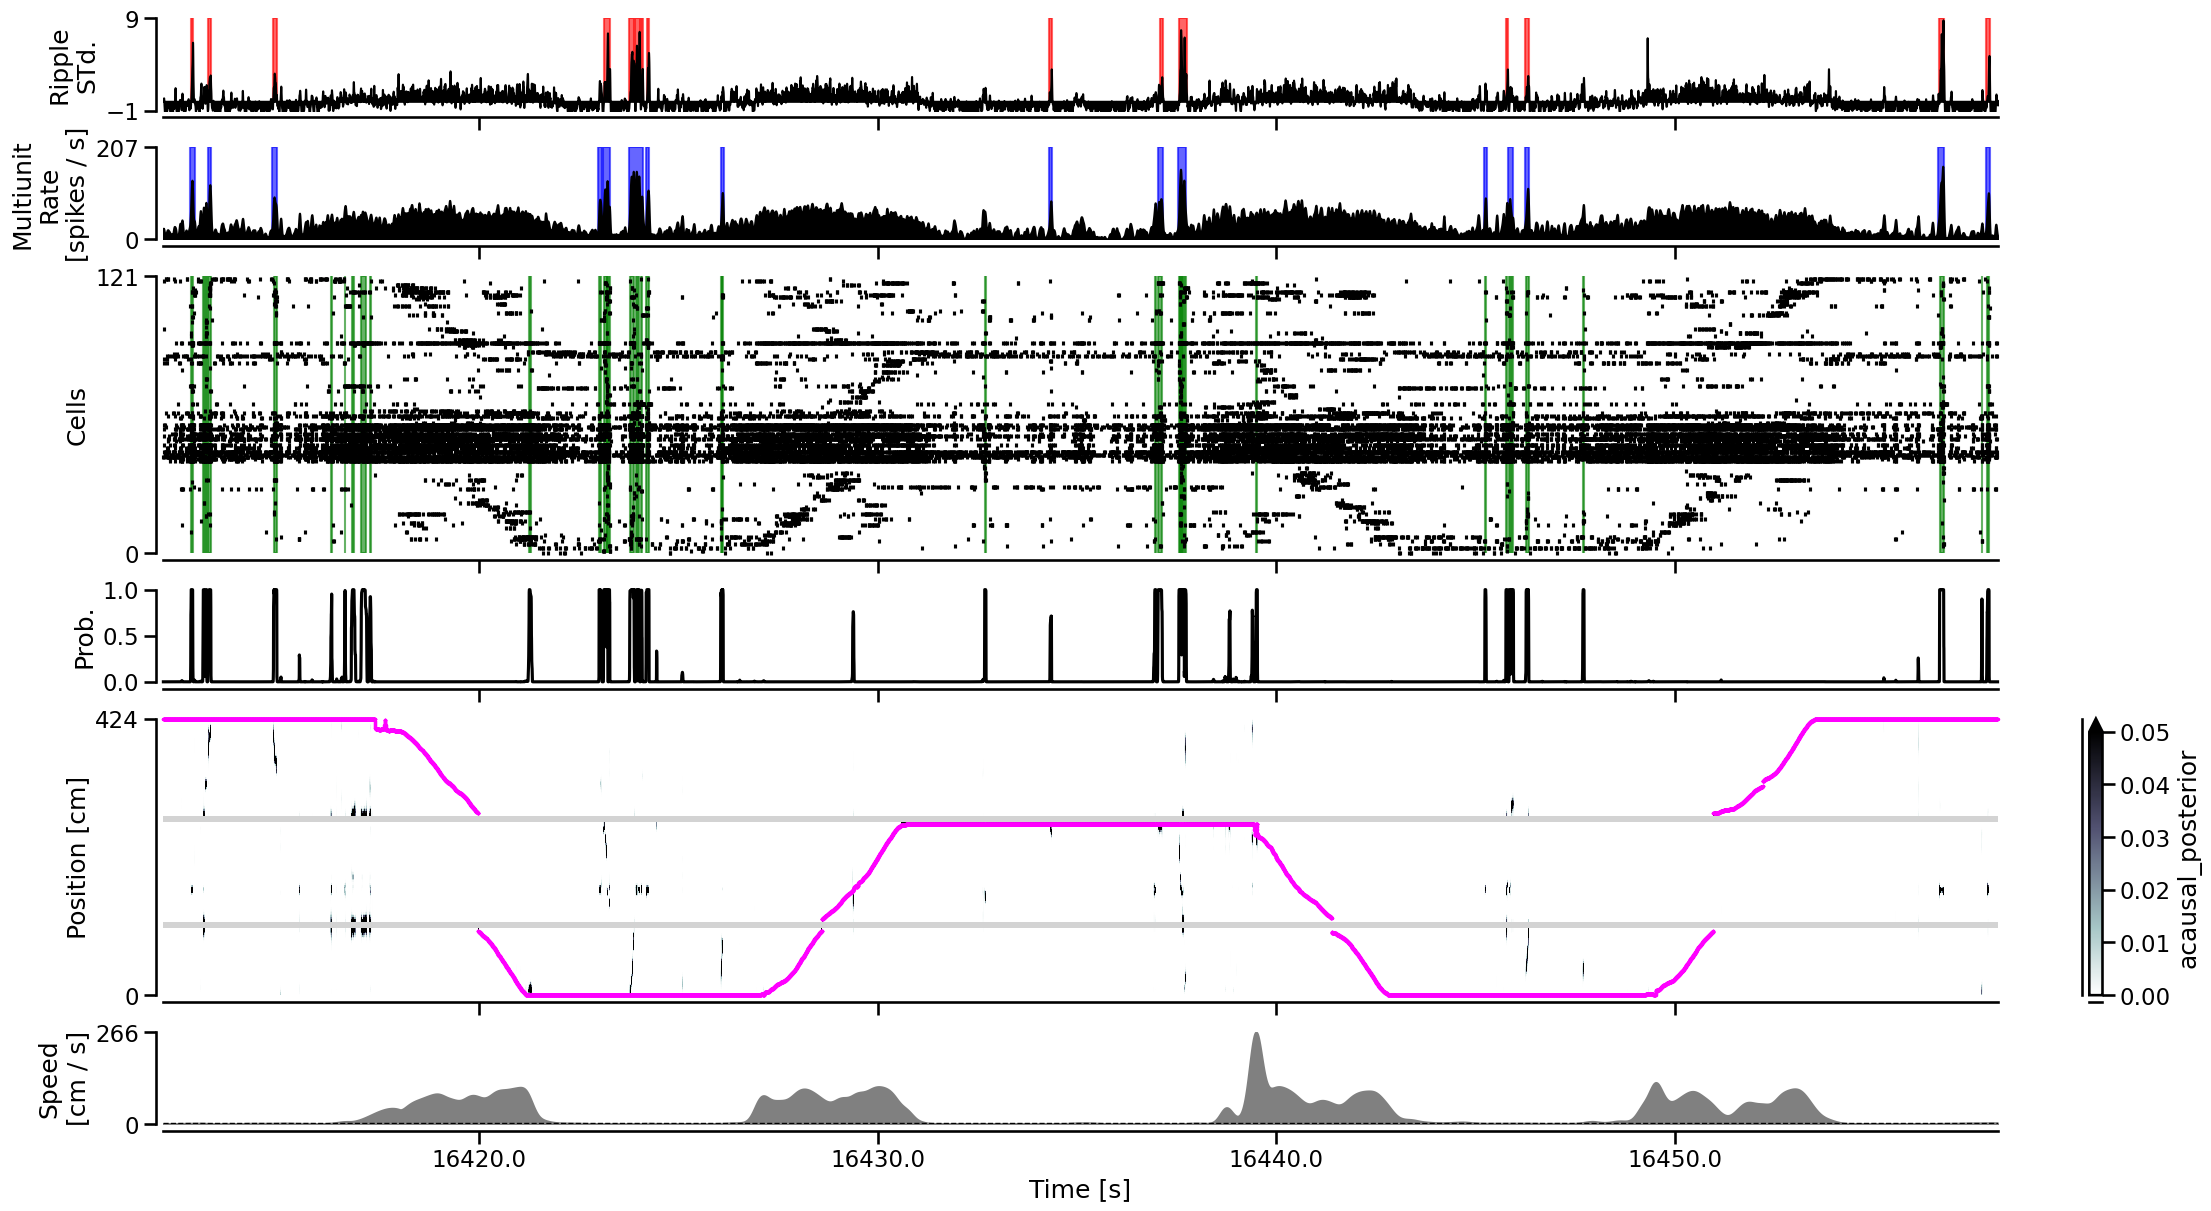

In [15]:
time_slice = slice(22_000, 45_000)
plot_detector(time_slice, data, replay_detector, results, figsize=(22, 12.0))

In [252]:
fit_args = dict(
    is_ripple=data['is_ripple'],
    is_training=~data['is_ripple'].values.squeeze(),
    speed=data['position_info'].nose_vel,
    position=data['position_info'].linear_position,
    spikes=data['spikes'],
    track_graph=data['track_graph'],
    edge_order=WTRACK_EDGE_ORDER,
    edge_spacing=WTRACK_EDGE_SPACING)
predict_args = dict(
    speed=data['position_info'].nose_vel,
    position=data['position_info'].linear_position,
    spikes=data['spikes'],
    time=data['position_info'].index / np.timedelta64(1, 's'),
    use_likelihoods=['spikes'],
    use_acausal=True,
    set_no_spike_to_equally_likely=False
)


replay_detector_likelihood_only = ReplayDetector(**detector_parameters)
(results_likelihood_only,
 data_log_likelihoods_likelihood_only
) = replay_detector_likelihood_only.estimate_parameters(
    fit_args=fit_args,
    predict_args=predict_args,
    estimate_state_transition=False,
    estimate_likelihood=True)

22-Dec-21 09:25:53 Fitting speed model...
22-Dec-21 09:25:54 Fitting spiking model...
22-Dec-21 09:30:11 Fitting replay movement state transition...
22-Dec-21 09:30:12 Fitting replay state transition...
22-Dec-21 09:30:12 Predicting spikes likelihood...


neurons:   0%|          | 0/121 [00:00<?, ?it/s]

neurons:   0%|          | 0/121 [00:00<?, ?it/s]

22-Dec-21 09:31:34 Finding causal non-local probability and position...
22-Dec-21 09:31:42 Finding acausal non-local probability and position...
22-Dec-21 09:32:13 iteration 0, likelihood: -281176.35270548024
22-Dec-21 09:32:14 Fitting speed model...
22-Dec-21 09:32:15 Fitting spiking model...
22-Dec-21 09:36:28 Fitting replay movement state transition...
22-Dec-21 09:36:28 Predicting spikes likelihood...


neurons:   0%|          | 0/121 [00:00<?, ?it/s]

neurons:   0%|          | 0/121 [00:00<?, ?it/s]

22-Dec-21 09:37:47 Finding causal non-local probability and position...
22-Dec-21 09:37:56 Finding acausal non-local probability and position...
22-Dec-21 09:38:26 iteration 1, likelihood: -293626.5310587899, change: -12450.178353309631
22-Dec-21 09:38:26 Fitting speed model...
22-Dec-21 09:38:27 Fitting spiking model...
22-Dec-21 09:42:40 Fitting replay movement state transition...
22-Dec-21 09:42:40 Predicting spikes likelihood...


neurons:   0%|          | 0/121 [00:00<?, ?it/s]

neurons:   0%|          | 0/121 [00:00<?, ?it/s]

22-Dec-21 09:44:02 Finding causal non-local probability and position...
22-Dec-21 09:44:12 Finding acausal non-local probability and position...
22-Dec-21 09:44:45 iteration 2, likelihood: -302749.7116092031, change: -9123.180550413206
22-Dec-21 09:44:45 Fitting speed model...
22-Dec-21 09:44:46 Fitting spiking model...
22-Dec-21 09:48:56 Fitting replay movement state transition...
22-Dec-21 09:48:56 Predicting spikes likelihood...


neurons:   0%|          | 0/121 [00:00<?, ?it/s]

neurons:   0%|          | 0/121 [00:00<?, ?it/s]

22-Dec-21 09:50:16 Finding causal non-local probability and position...
22-Dec-21 09:50:25 Finding acausal non-local probability and position...
22-Dec-21 09:51:01 iteration 3, likelihood: -352978.31311407743, change: -50228.60150487436
22-Dec-21 09:51:01 Fitting speed model...
22-Dec-21 09:51:02 Fitting spiking model...
22-Dec-21 09:55:03 Fitting replay movement state transition...
22-Dec-21 09:55:03 Predicting spikes likelihood...


neurons:   0%|          | 0/121 [00:00<?, ?it/s]

neurons:   0%|          | 0/121 [00:00<?, ?it/s]

22-Dec-21 09:56:22 Finding causal non-local probability and position...
22-Dec-21 09:56:32 Finding acausal non-local probability and position...
22-Dec-21 09:57:05 iteration 4, likelihood: -395570.52770641143, change: -42592.214592334
22-Dec-21 09:57:05 Fitting speed model...
22-Dec-21 09:57:07 Fitting spiking model...
22-Dec-21 10:01:00 Fitting replay movement state transition...
22-Dec-21 10:01:00 Predicting spikes likelihood...


neurons:   0%|          | 0/121 [00:00<?, ?it/s]

neurons:   0%|          | 0/121 [00:00<?, ?it/s]

22-Dec-21 10:02:21 Finding causal non-local probability and position...
22-Dec-21 10:02:30 Finding acausal non-local probability and position...
22-Dec-21 10:03:06 iteration 5, likelihood: -406016.0607072429, change: -10445.533000831492
22-Dec-21 10:03:06 Fitting speed model...
22-Dec-21 10:03:07 Fitting spiking model...
22-Dec-21 10:07:00 Fitting replay movement state transition...
22-Dec-21 10:07:01 Predicting spikes likelihood...


neurons:   0%|          | 0/121 [00:00<?, ?it/s]

neurons:   0%|          | 0/121 [00:00<?, ?it/s]

22-Dec-21 10:08:21 Finding causal non-local probability and position...
22-Dec-21 10:08:30 Finding acausal non-local probability and position...
22-Dec-21 10:09:03 iteration 6, likelihood: -408621.05892953975, change: -2604.9982222968247
22-Dec-21 10:09:03 Fitting speed model...
22-Dec-21 10:09:04 Fitting spiking model...
22-Dec-21 10:12:58 Fitting replay movement state transition...
22-Dec-21 10:12:58 Predicting spikes likelihood...


neurons:   0%|          | 0/121 [00:00<?, ?it/s]

neurons:   0%|          | 0/121 [00:00<?, ?it/s]

22-Dec-21 10:14:16 Finding causal non-local probability and position...
22-Dec-21 10:14:25 Finding acausal non-local probability and position...
22-Dec-21 10:14:56 iteration 7, likelihood: -405776.8174601999, change: 2844.241469339875
22-Dec-21 10:14:56 Fitting speed model...
22-Dec-21 10:14:57 Fitting spiking model...
22-Dec-21 10:18:52 Fitting replay movement state transition...
22-Dec-21 10:18:52 Predicting spikes likelihood...


neurons:   0%|          | 0/121 [00:00<?, ?it/s]

neurons:   0%|          | 0/121 [00:00<?, ?it/s]

22-Dec-21 10:20:13 Finding causal non-local probability and position...
22-Dec-21 10:20:22 Finding acausal non-local probability and position...
22-Dec-21 10:21:01 iteration 8, likelihood: -403612.32629968773, change: 2164.491160512145
22-Dec-21 10:21:01 Fitting speed model...
22-Dec-21 10:21:03 Fitting spiking model...
22-Dec-21 10:24:55 Fitting replay movement state transition...
22-Dec-21 10:24:56 Predicting spikes likelihood...


neurons:   0%|          | 0/121 [00:00<?, ?it/s]

neurons:   0%|          | 0/121 [00:00<?, ?it/s]

22-Dec-21 10:26:16 Finding causal non-local probability and position...
22-Dec-21 10:26:25 Finding acausal non-local probability and position...
22-Dec-21 10:26:59 iteration 9, likelihood: -400517.1428892754, change: 3095.183410412341
22-Dec-21 10:26:59 Fitting speed model...
22-Dec-21 10:27:01 Fitting spiking model...
22-Dec-21 10:30:53 Fitting replay movement state transition...
22-Dec-21 10:30:53 Predicting spikes likelihood...


neurons:   0%|          | 0/121 [00:00<?, ?it/s]

neurons:   0%|          | 0/121 [00:00<?, ?it/s]

22-Dec-21 10:32:13 Finding causal non-local probability and position...
22-Dec-21 10:32:21 Finding acausal non-local probability and position...
22-Dec-21 10:32:52 iteration 10, likelihood: -397279.4806430056, change: 3237.662246269814
22-Dec-21 10:32:52 Fitting speed model...
22-Dec-21 10:32:53 Fitting spiking model...
22-Dec-21 10:36:47 Fitting replay movement state transition...
22-Dec-21 10:36:47 Predicting spikes likelihood...


neurons:   0%|          | 0/121 [00:00<?, ?it/s]

neurons:   0%|          | 0/121 [00:00<?, ?it/s]

22-Dec-21 10:38:06 Finding causal non-local probability and position...
22-Dec-21 10:38:15 Finding acausal non-local probability and position...
22-Dec-21 10:38:51 iteration 11, likelihood: -394211.3965205275, change: 3068.084122478089


In [264]:
replay_detector_st_only = ReplayDetector(**detector_parameters).fit(**fit_args)
(results_st_only,
 data_log_likelihoods_st_only
) = replay_detector_st_only.estimate_parameters(
    fit_args=fit_args,
    predict_args=predict_args,
    estimate_state_transition=True,
    estimate_likelihood=False)

22-Dec-21 11:43:12 Fitting speed model...
22-Dec-21 11:43:14 Fitting spiking model...
22-Dec-21 11:47:07 Fitting replay movement state transition...
22-Dec-21 11:47:07 Fitting speed model...
22-Dec-21 11:47:08 Fitting spiking model...
22-Dec-21 11:51:02 Fitting replay movement state transition...
22-Dec-21 11:51:02 Predicting spikes likelihood...


neurons:   0%|          | 0/121 [00:00<?, ?it/s]

neurons:   0%|          | 0/121 [00:00<?, ?it/s]

AttributeError: 'ReplayDetector' object has no attribute 'replay_state_transition_'

In [ ]:
replay_detector_all = ReplayDetector(**detector_parameters)

(results_all,
 data_log_likelihoods_all
) = replay_detector_all.estimate_parameters(
    fit_args=fit_args,
    predict_args=predict_args,
    estimate_state_transition=True,
    estimate_likelihood=True)

In [18]:
results

<xarray.Dataset>
Dimensions:                (time: 448713, state: 2, position: 161)
Coordinates:
  * time                   (time) float64 1.637e+04 1.637e+04 ... 1.727e+04
  * position               (position) float64 1.249 3.747 6.246 ... 419.9 422.4
  * state                  (state) <U9 'Local' 'Non-Local'
Data variables:
    causal_posterior       (time, state, position) float64 0.0 0.0 ... 8.471e-07
    likelihood             (time, state, position) float64 1.0 1.0 ... 1.0
    acausal_posterior      (time, state, position) float64 0.0 0.0 ... 8.471e-07
    non_local_probability  (time) float64 0.0 0.0001129 ... 0.9869 0.9819
Attributes:
    data_log_likelihood:  -281176.35270548024

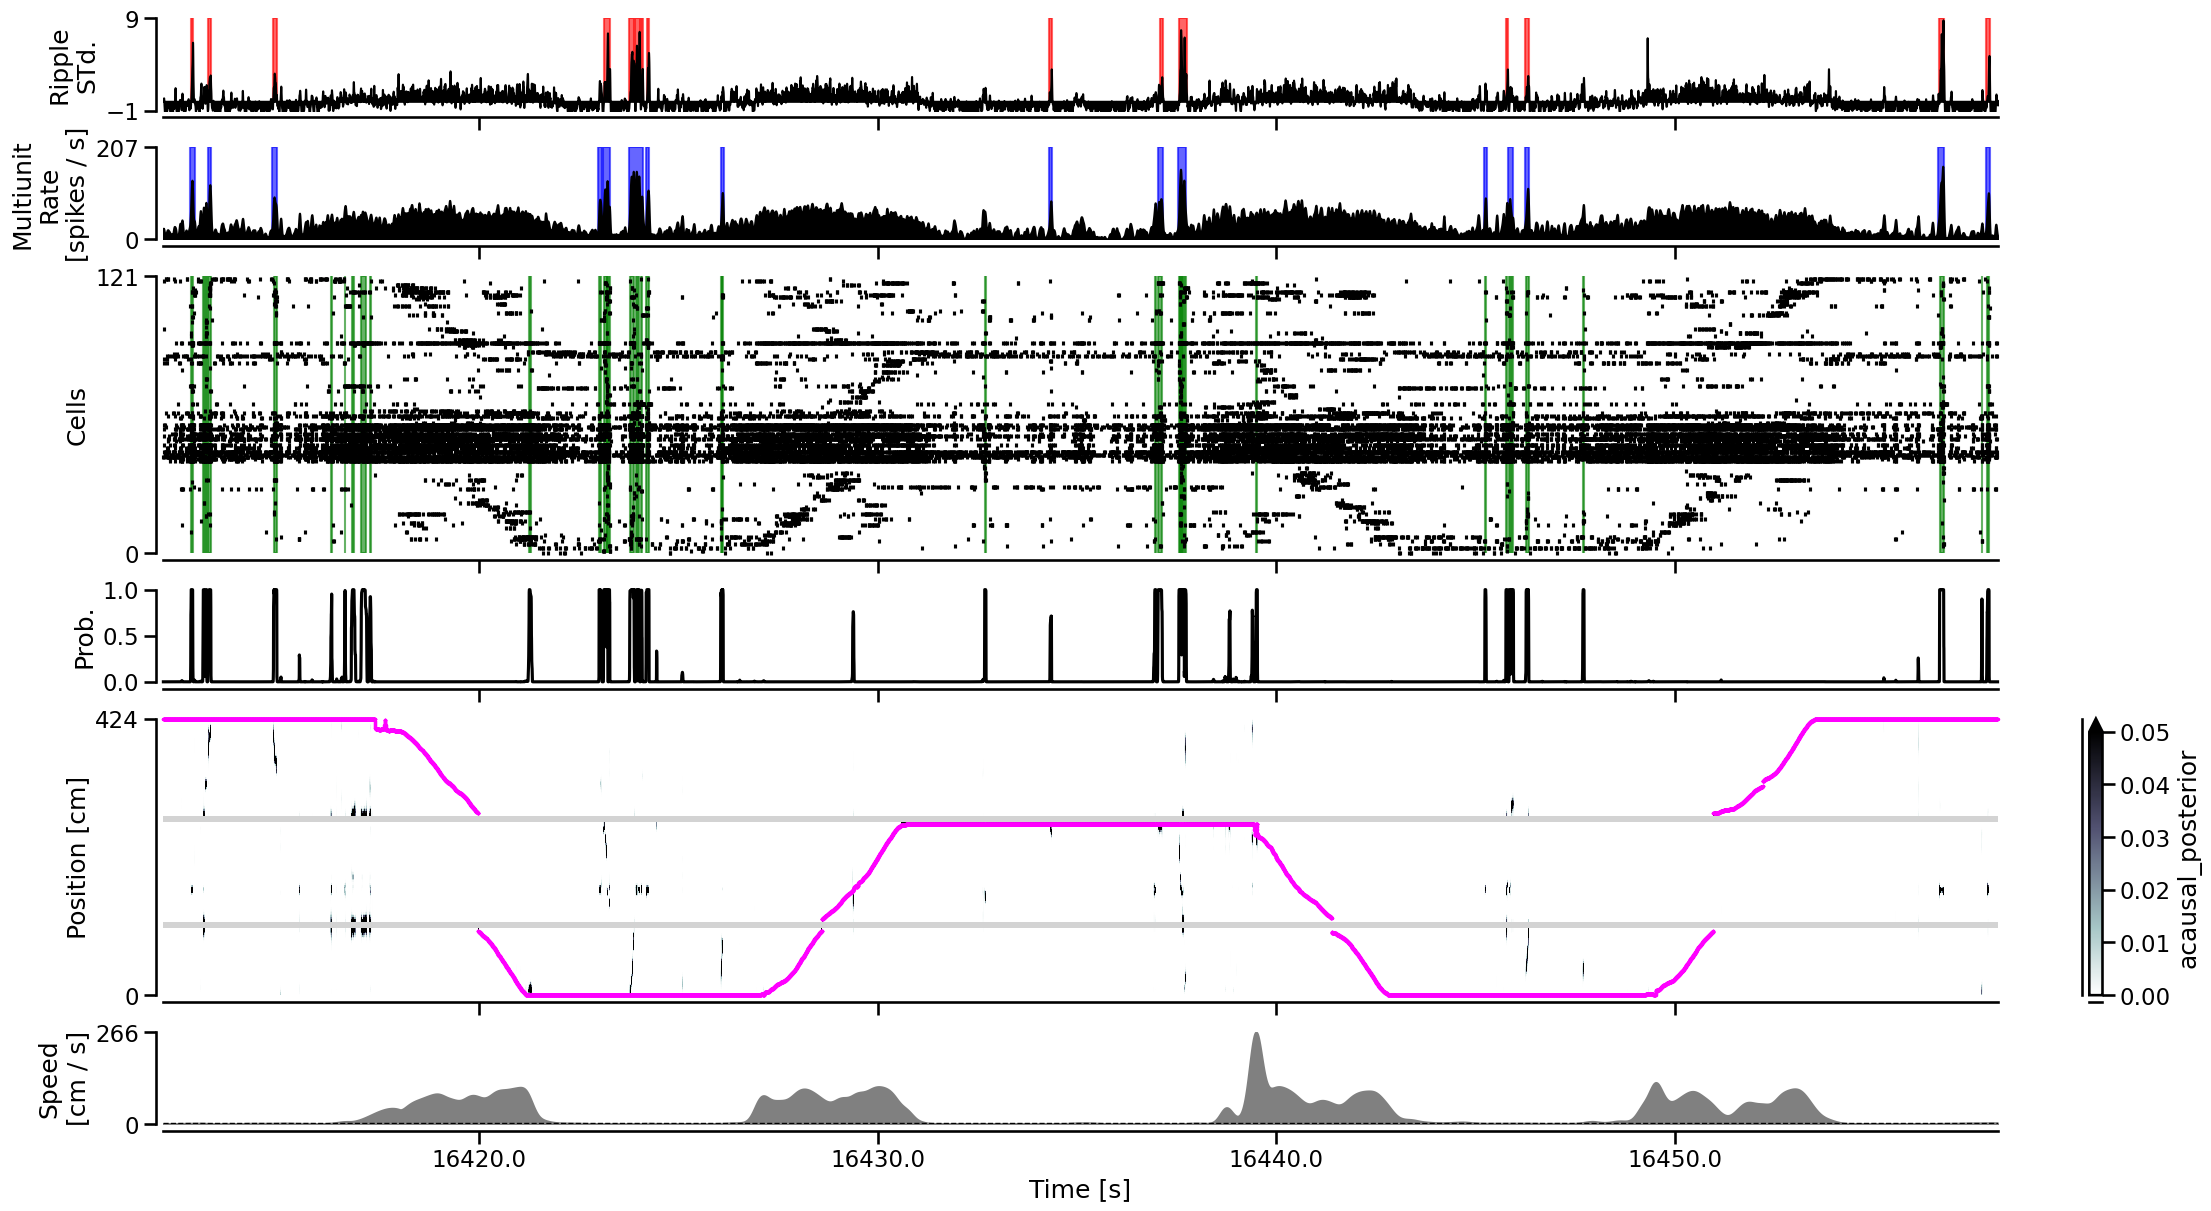

In [19]:
time_slice = slice(22_000, 45_000)
plot_detector(time_slice, data, replay_detector, results, figsize=(22, 12.0))

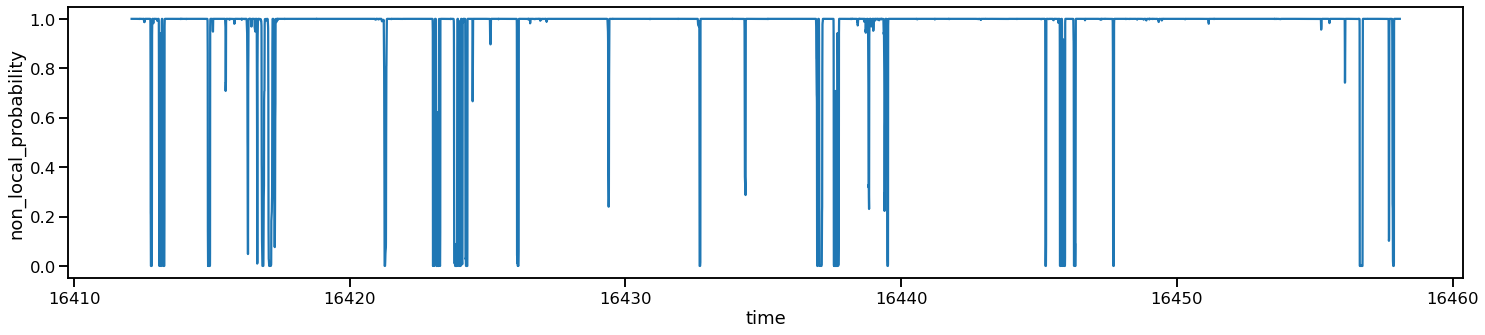

In [23]:
(1 - results.non_local_probability.isel(time=time_slice)).plot(x='time', size=5, aspect=5)

In [25]:
replay_detector2 = ReplayDetector(**detector_parameters)
replay_detector2.fit(
    is_ripple=data['is_ripple'],
    is_training=(1 - results.non_local_probability).values,
    speed=data['position_info'].nose_vel,
    position=data['position_info'].linear_position,
    spikes=data['spikes'],
    track_graph=data['track_graph'],
    edge_order=WTRACK_EDGE_ORDER,
    edge_spacing=WTRACK_EDGE_SPACING)

22-Dec-21 08:28:27 Fitting speed model...
22-Dec-21 08:28:28 Fitting spiking model...
22-Dec-21 08:32:47 Fitting replay movement state transition...
22-Dec-21 08:32:47 Fitting replay state transition...


ReplayDetector(discrete_diagonal=None,
               discrete_state_transition_type='ripples_no_speed_threshold',
               infer_track_interior=True, is_track_interior=None,
               lfp_model=<class 'sklearn.mixture._bayesian_mixture.BayesianGaussianMixture'>,
               lfp_model_kwargs={'max_iter': 200, 'n_components': 1,
                                 'tol': 1e-06},
               movement_state_transition_type='random_walk', movement_var=6.0,
               m...
               multiunit_model_kwargs={'bandwidth': array([20., 20., 20., 20.,  8.])},
               multiunit_occupancy_kwargs={'bandwidth': array([8.])},
               multiunit_occupancy_model=<class 'replay_identification.multiunit_likelihood.NumbaKDE'>,
               place_bin_size=2.5, position_range=None, replay_speed=1,
               replay_state_transition_penalty=1e-05, speed_knots=None,
               speed_threshold=4.0, spike_model_knot_spacing=8.0,
               spike_model_penalty=0.5

In [26]:
results2 = replay_detector2.predict(**predict_args)

22-Dec-21 08:32:48 Predicting spikes likelihood...


neurons:   0%|          | 0/121 [00:00<?, ?it/s]

neurons:   0%|          | 0/121 [00:00<?, ?it/s]

22-Dec-21 08:34:12 Finding causal non-local probability and position...
22-Dec-21 08:34:20 Finding acausal non-local probability and position...


In [27]:
results2.data_log_likelihood

-293626.5310587899

In [28]:
results.data_log_likelihood

-281176.35270548024

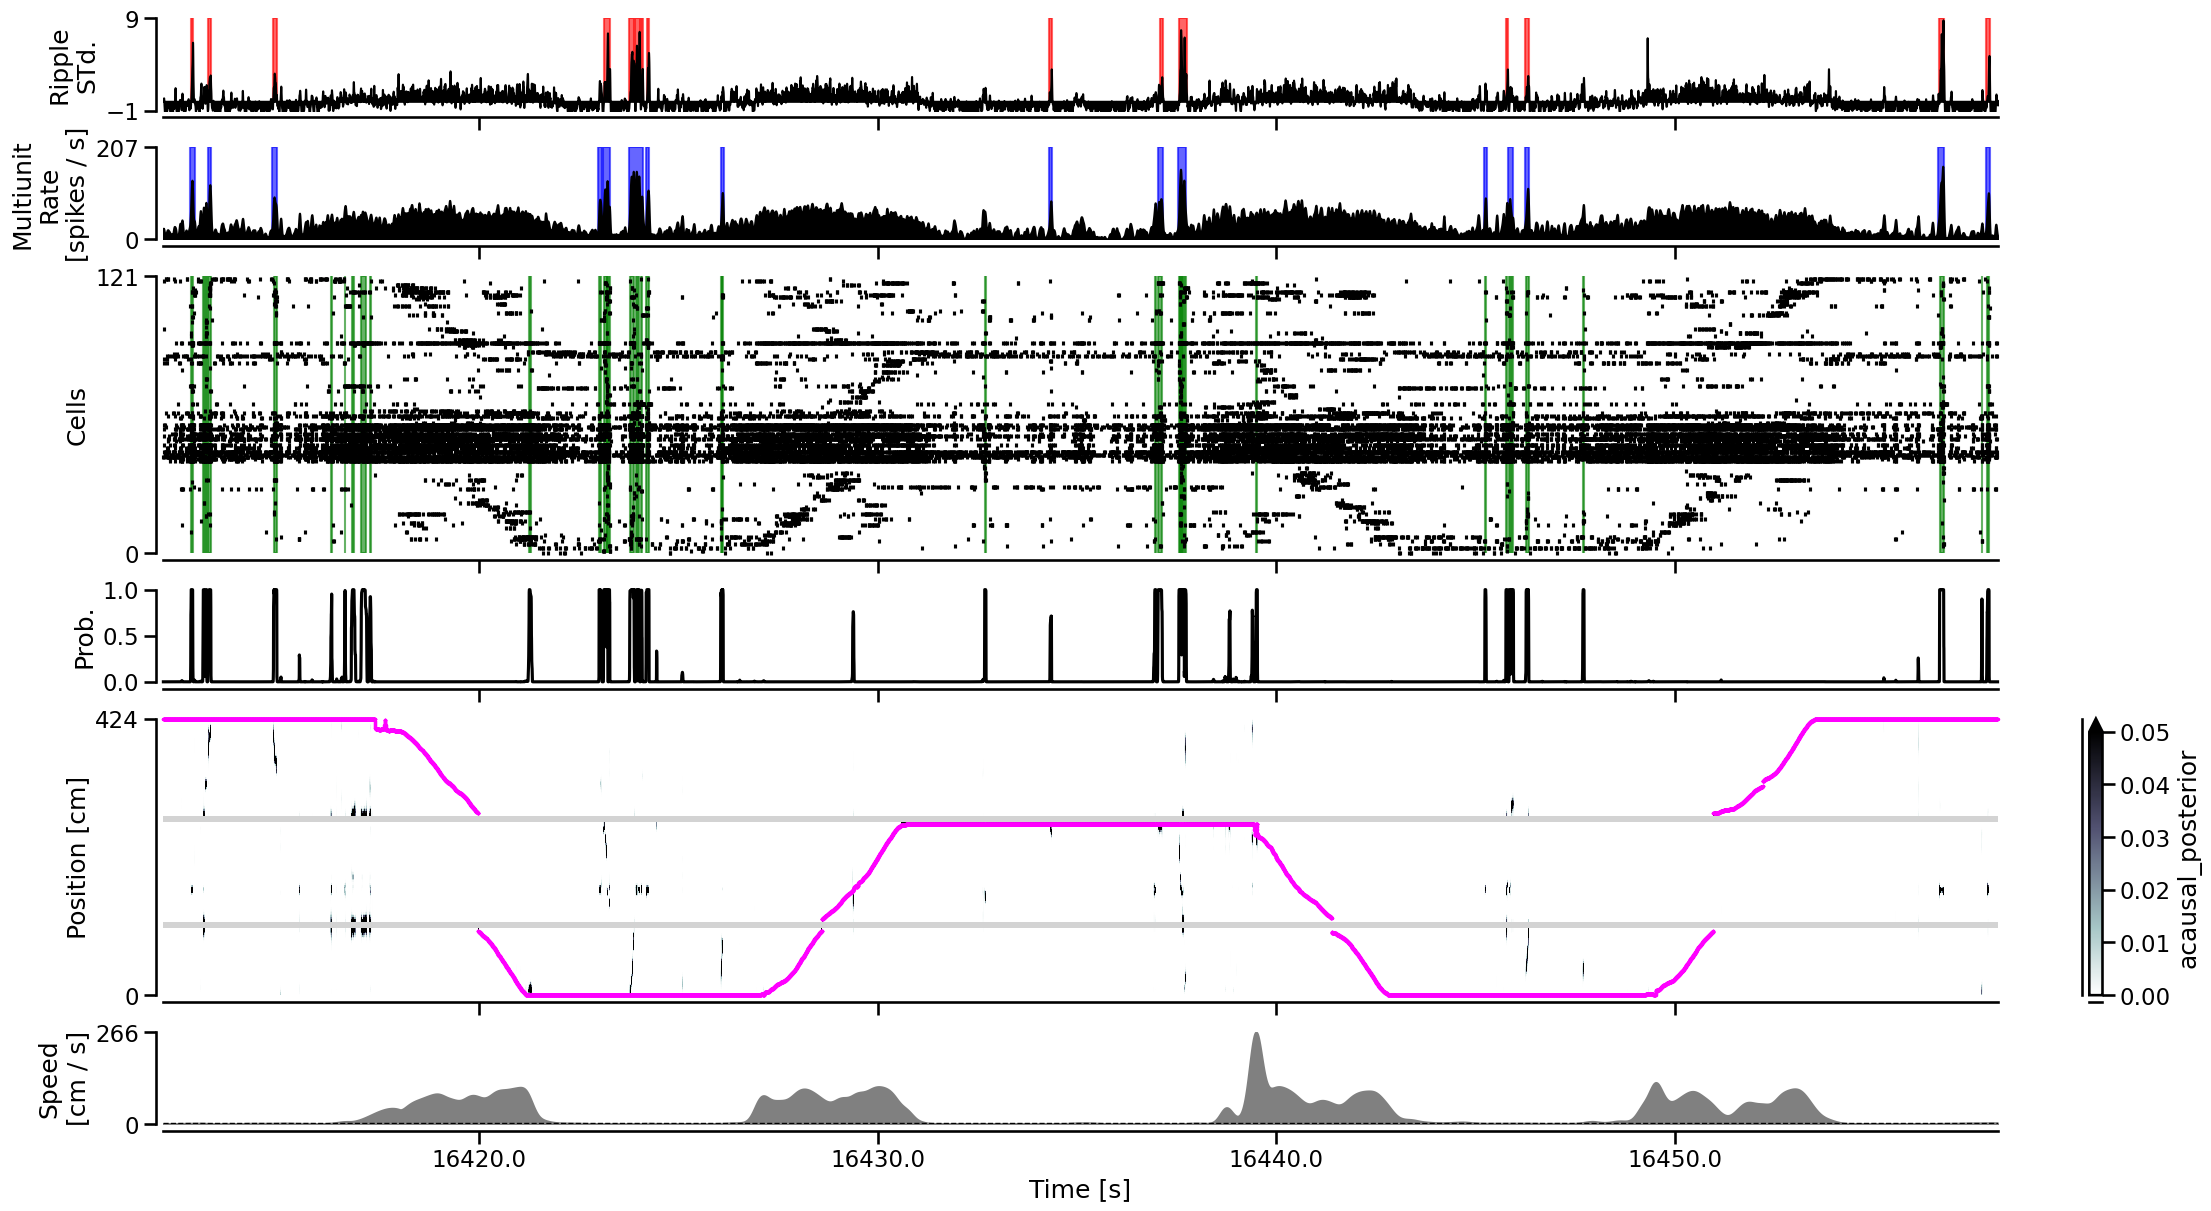

In [30]:
time_slice = slice(22_000, 45_000)
plot_detector(time_slice, data, replay_detector, results, figsize=(22, 12.0))

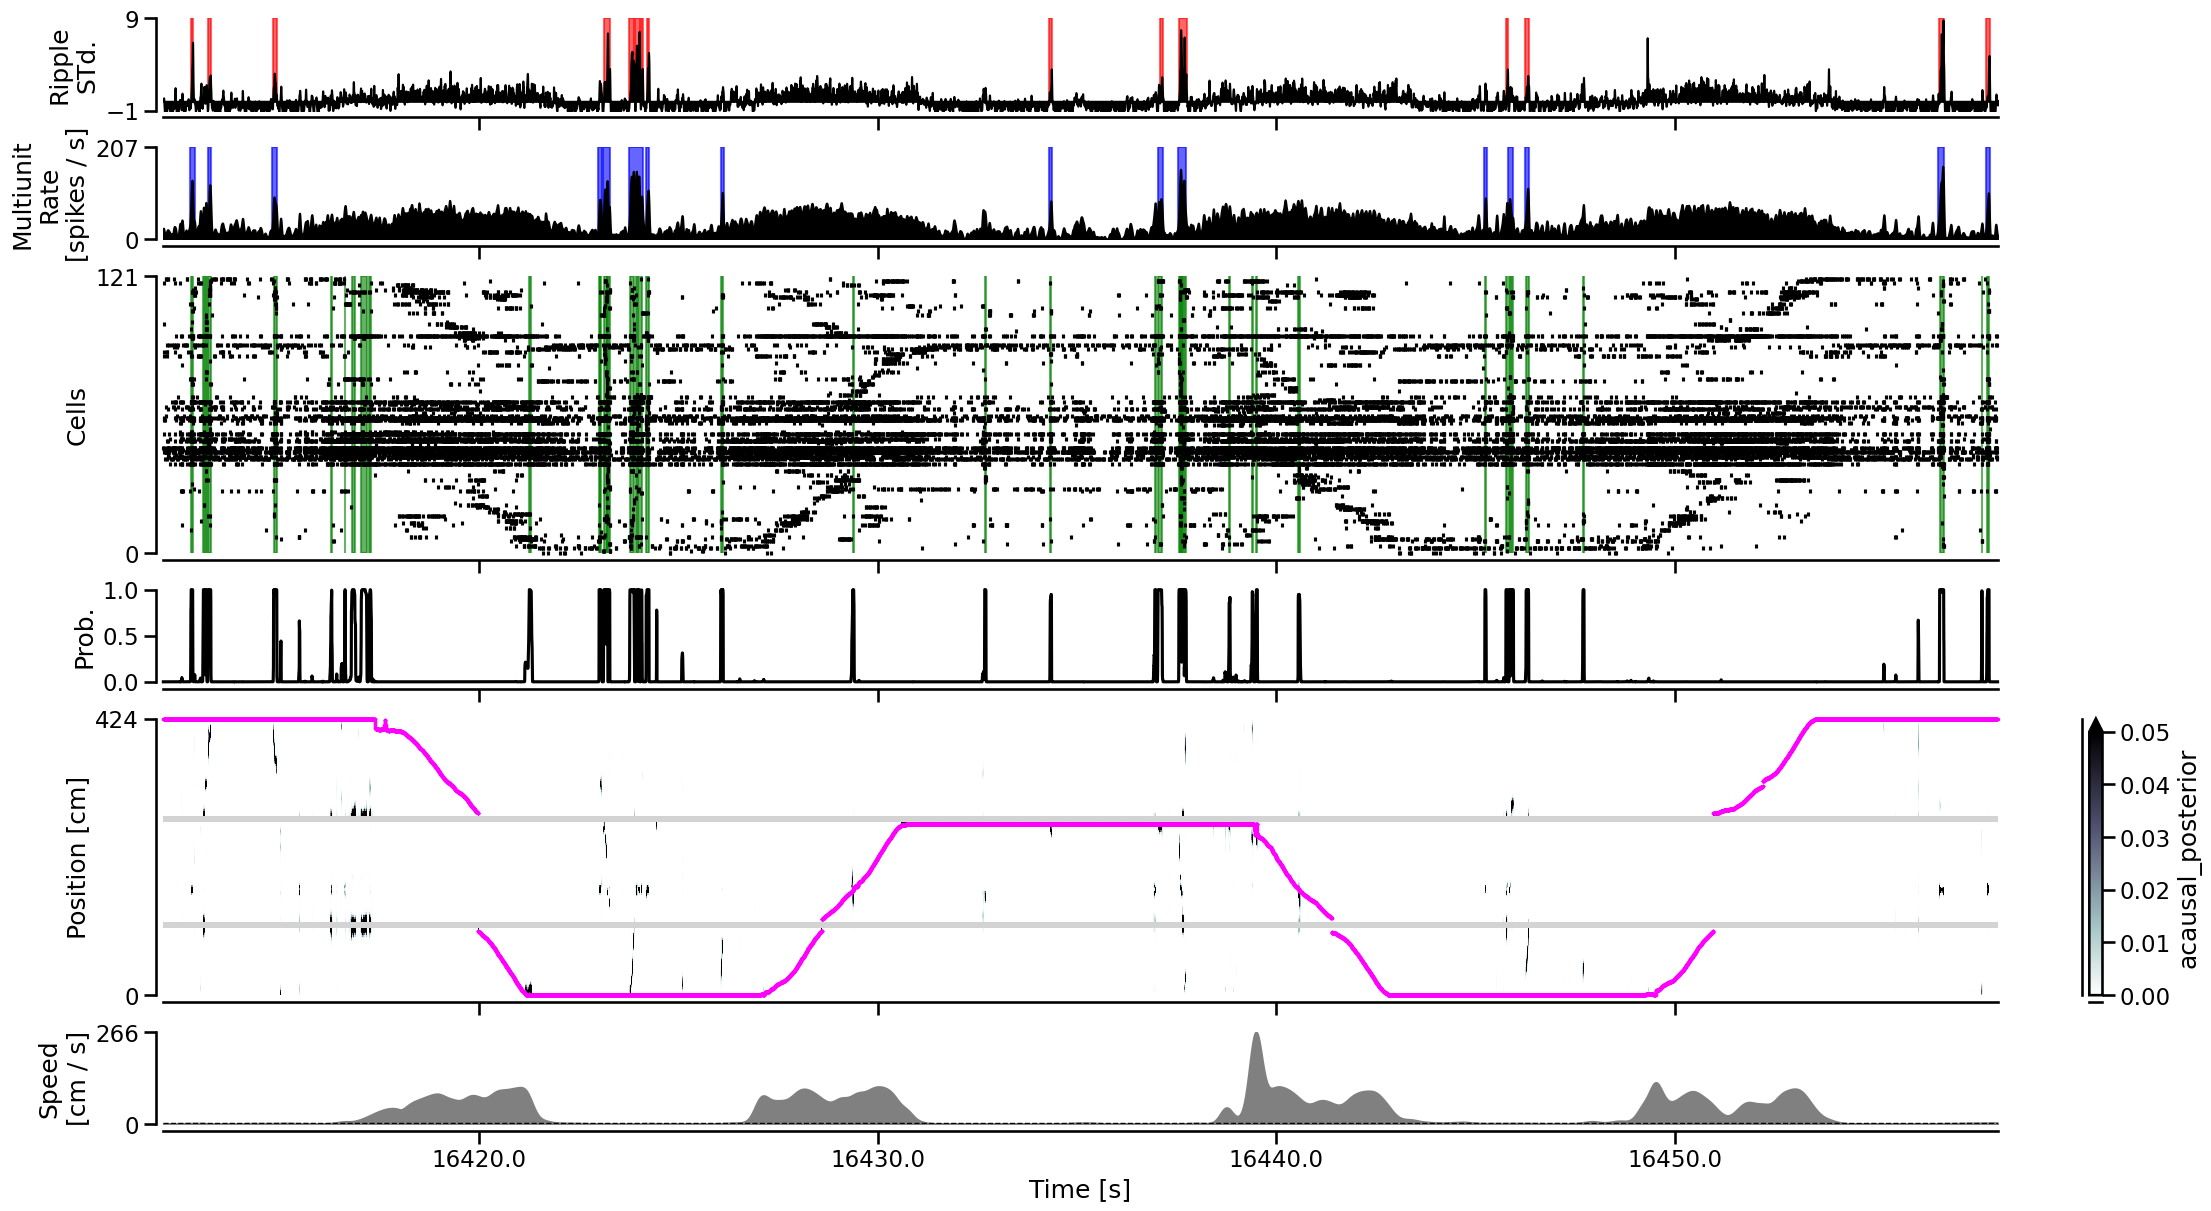

In [29]:
time_slice = slice(22_000, 45_000)
plot_detector(time_slice, data, replay_detector2, results2, figsize=(22, 12.0))

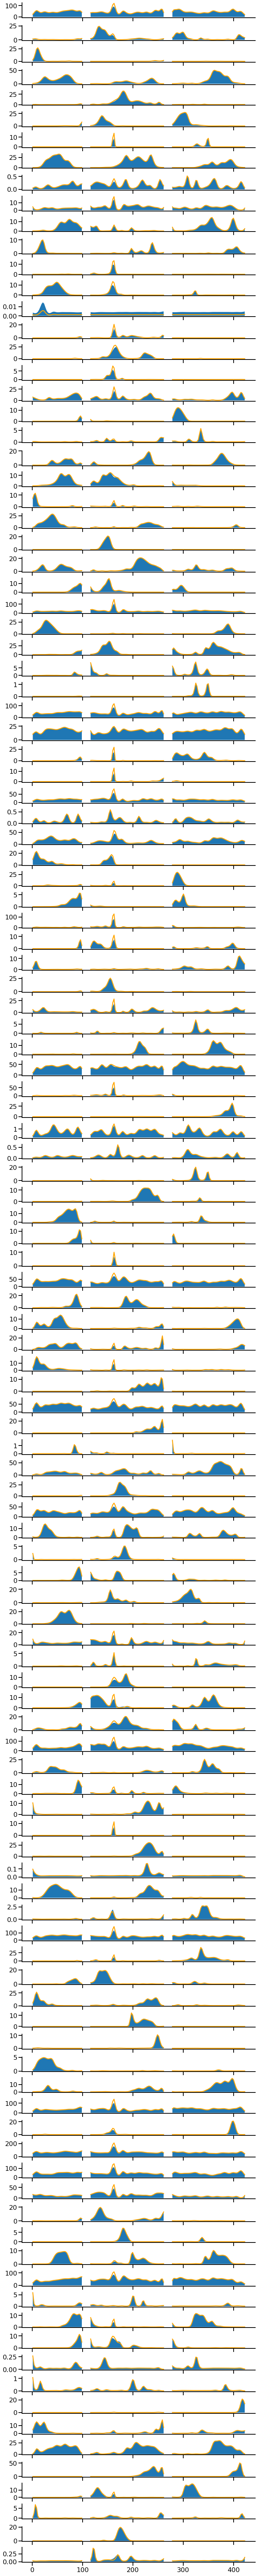

In [251]:
place_fields = replay_detector._spiking_likelihood.keywords['place_conditional_intensity']
place_fields2 = replay_detector2._spiking_likelihood.keywords['place_conditional_intensity']
place_fields[~replay_detector.is_track_interior_.squeeze(), :] = np.nan
place_fields2[~replay_detector.is_track_interior_.squeeze(), :] = np.nan

n_neurons = place_fields.shape[1]
fig, axes = plt.subplots(n_neurons, 1, figsize=(9, 0.75 * n_neurons),
                         sharex=True, constrained_layout=True)

for neuron_ind, ax in enumerate(axes.flat):
    ax.fill_between(replay_detector.place_bin_centers_.squeeze(),
                    place_fields[:, neuron_ind] * 500, alpha=1)
    ax.plot(replay_detector2.place_bin_centers_.squeeze(),
             place_fields2[:, neuron_ind] * 500, alpha=1, color='orange')
sns.despine()

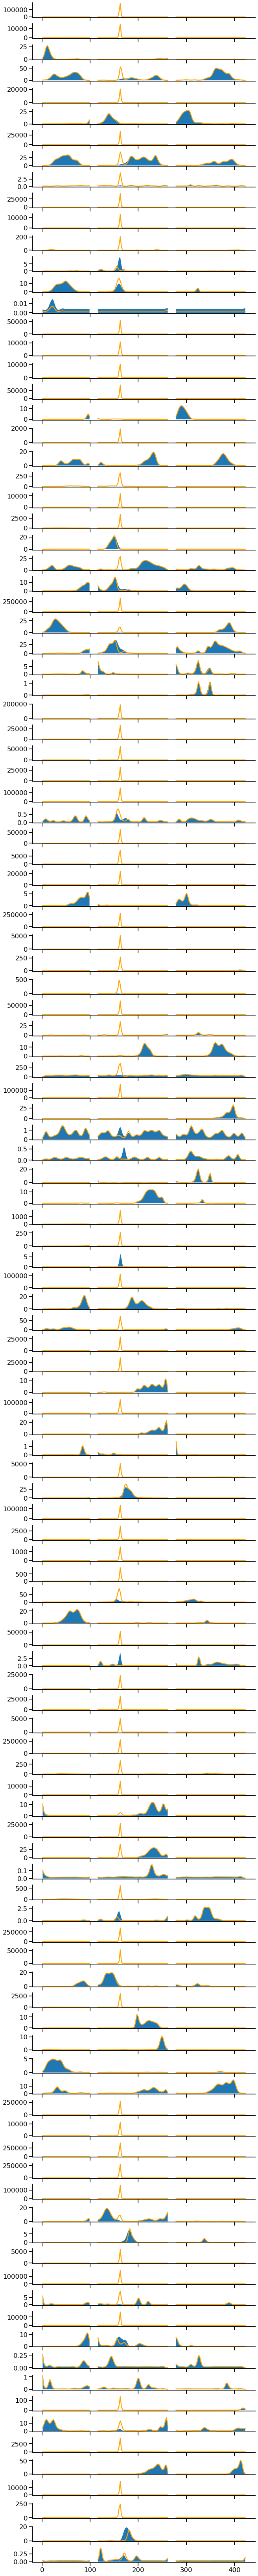

In [255]:
place_fields = replay_detector._spiking_likelihood.keywords['place_conditional_intensity']
place_fields2 = replay_detector_likelihood_only._spiking_likelihood.keywords['place_conditional_intensity']
place_fields[~replay_detector.is_track_interior_.squeeze(), :] = np.nan
place_fields2[~replay_detector_likelihood_only.is_track_interior_.squeeze(), :] = np.nan

n_neurons = place_fields.shape[1]
fig, axes = plt.subplots(n_neurons, 1, figsize=(9, 0.75 * n_neurons),
                         sharex=True, constrained_layout=True)

for neuron_ind, ax in enumerate(axes.flat):
    ax.fill_between(replay_detector.place_bin_centers_.squeeze(),
                    place_fields[:, neuron_ind] * 500, alpha=1)
    ax.plot(replay_detector_likelihood_only.place_bin_centers_.squeeze(),
             place_fields2[:, neuron_ind] * 500, alpha=1, color='orange')
sns.despine()

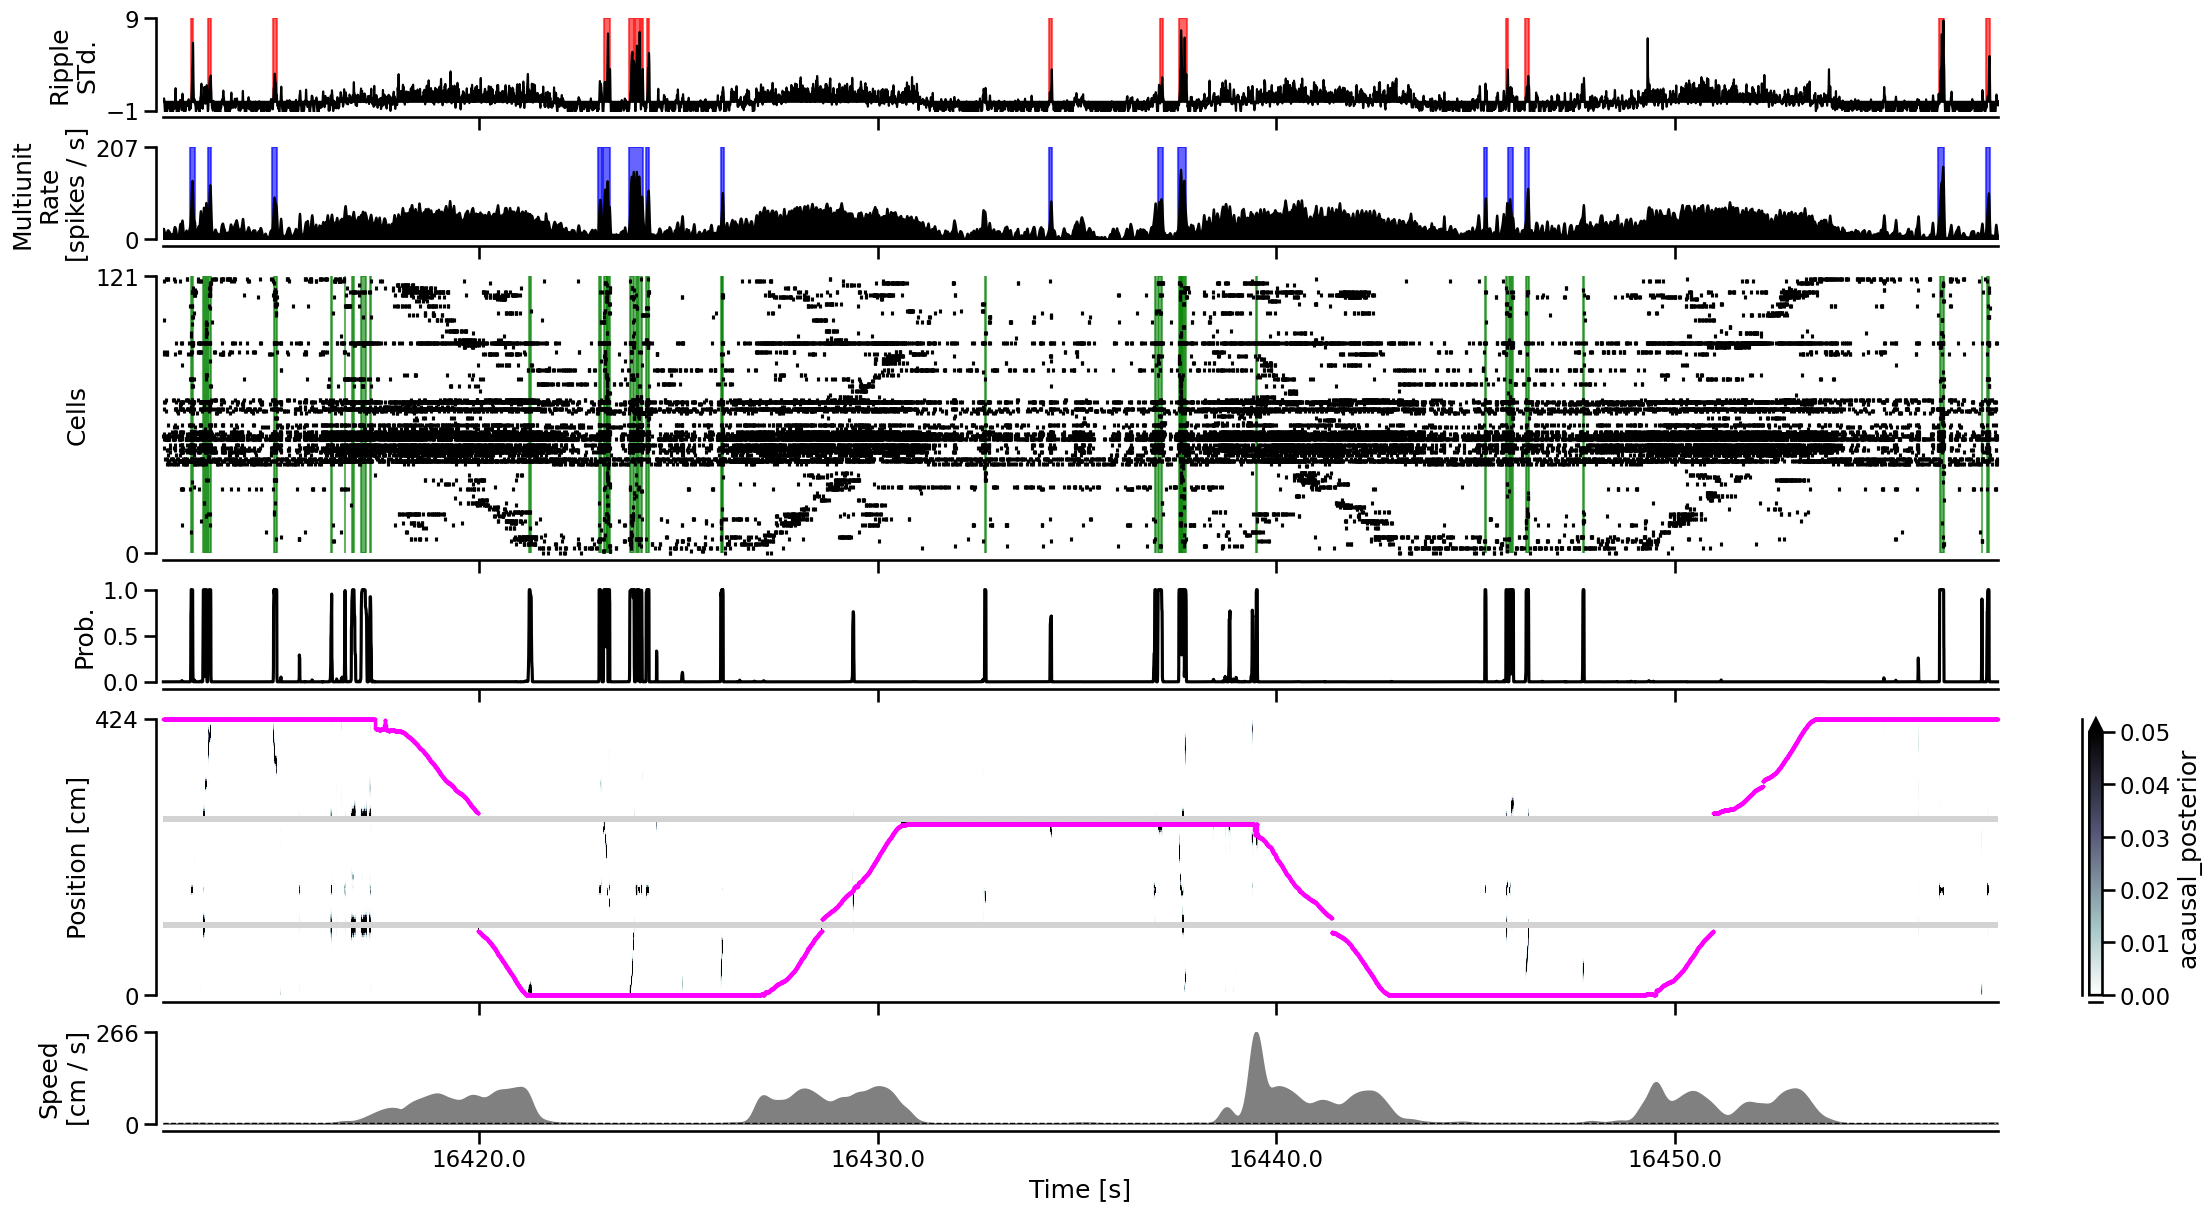

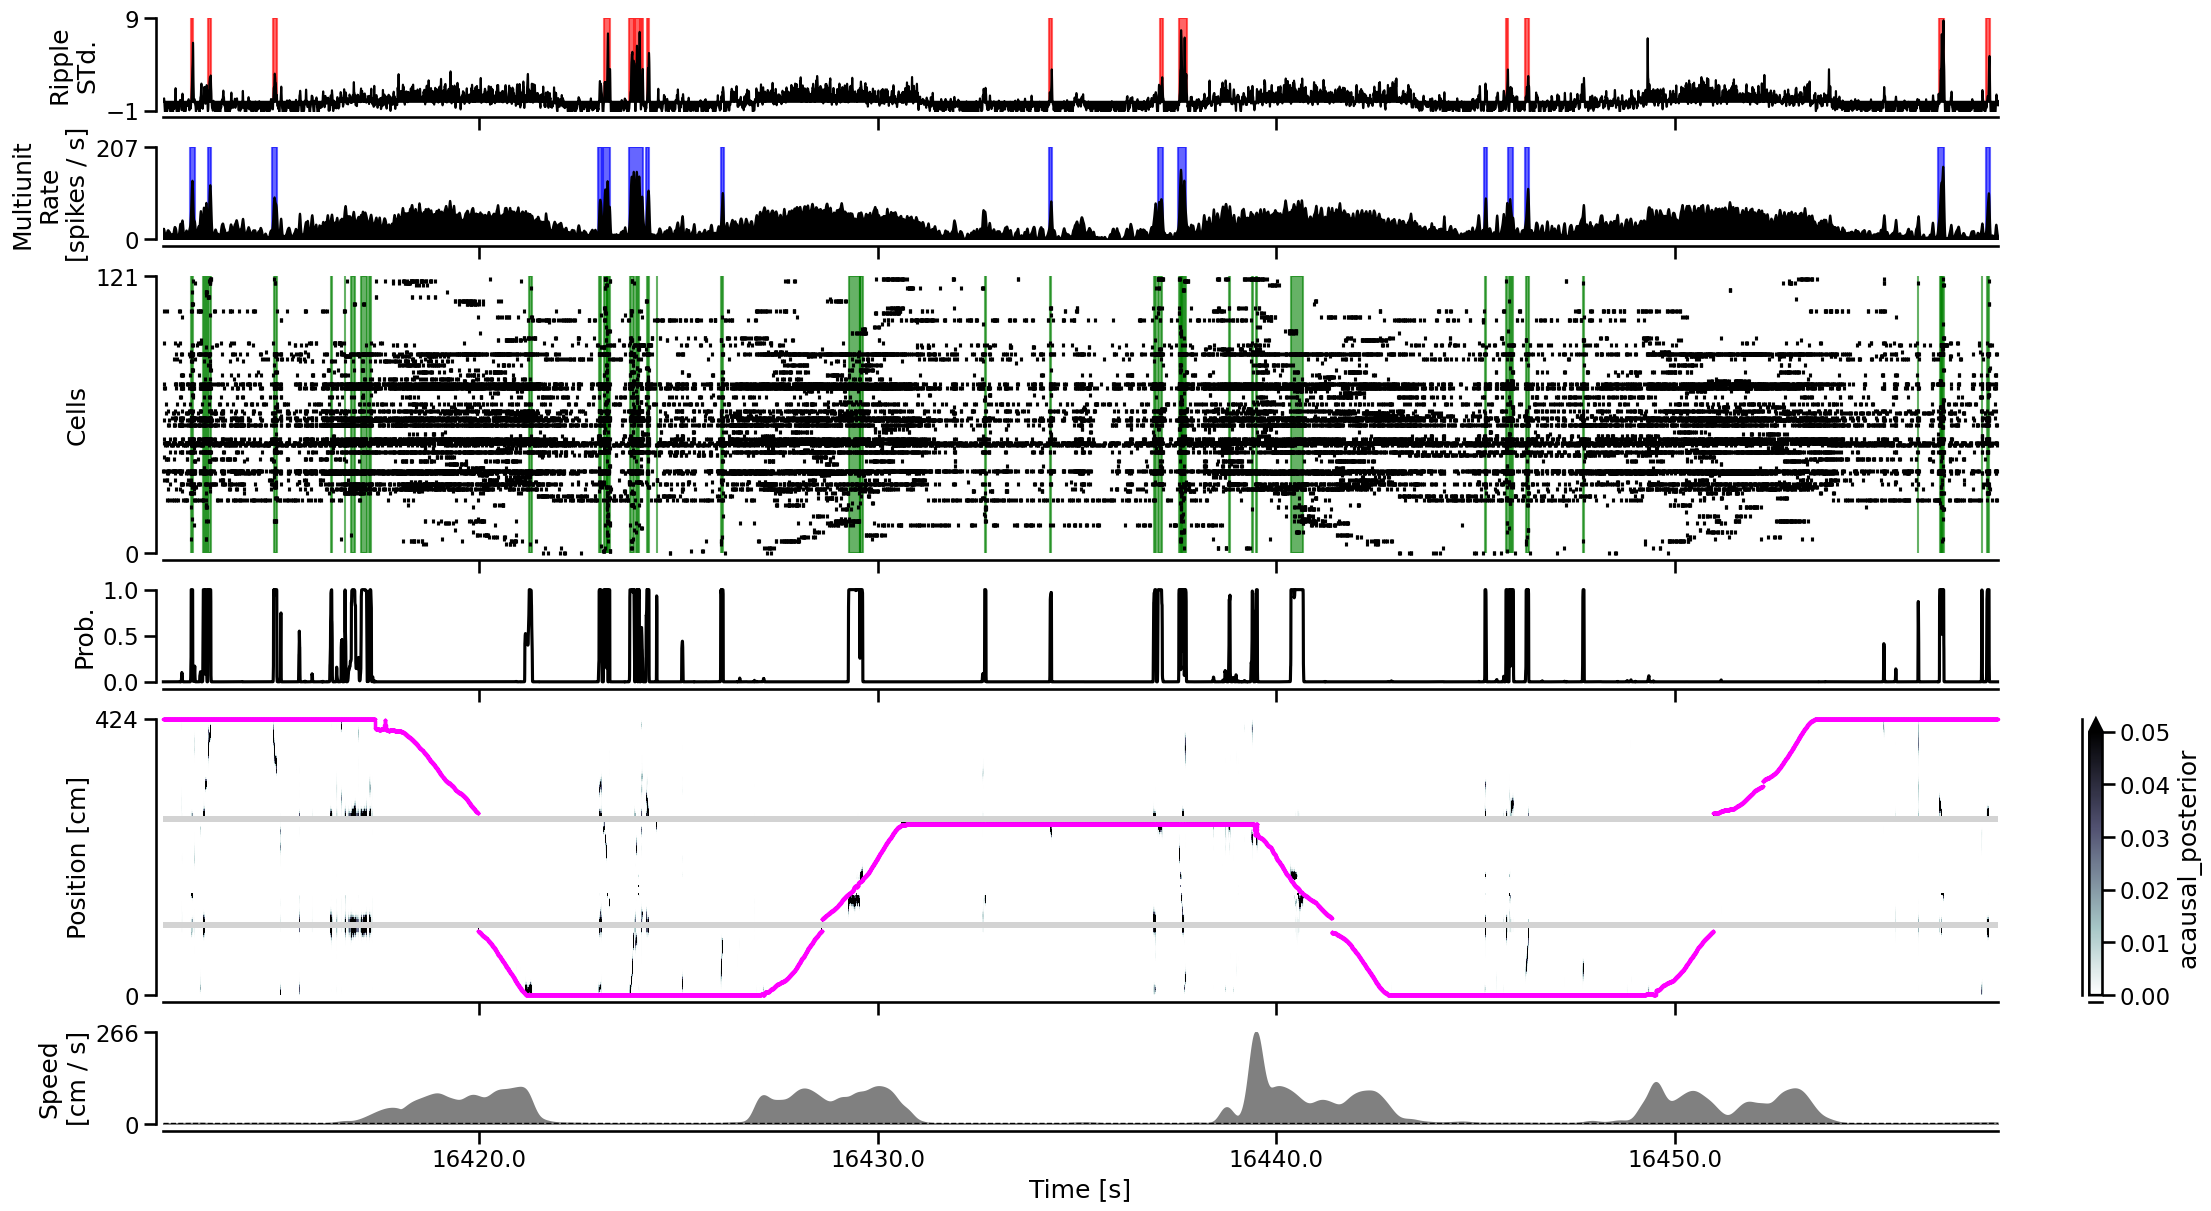

In [257]:
time_slice = slice(22_000, 45_000)
plot_detector(time_slice, data, replay_detector, results, figsize=(22, 12.0))
plot_detector(time_slice, data, replay_detector_likelihood_only, results_likelihood_only, figsize=(22, 12.0))

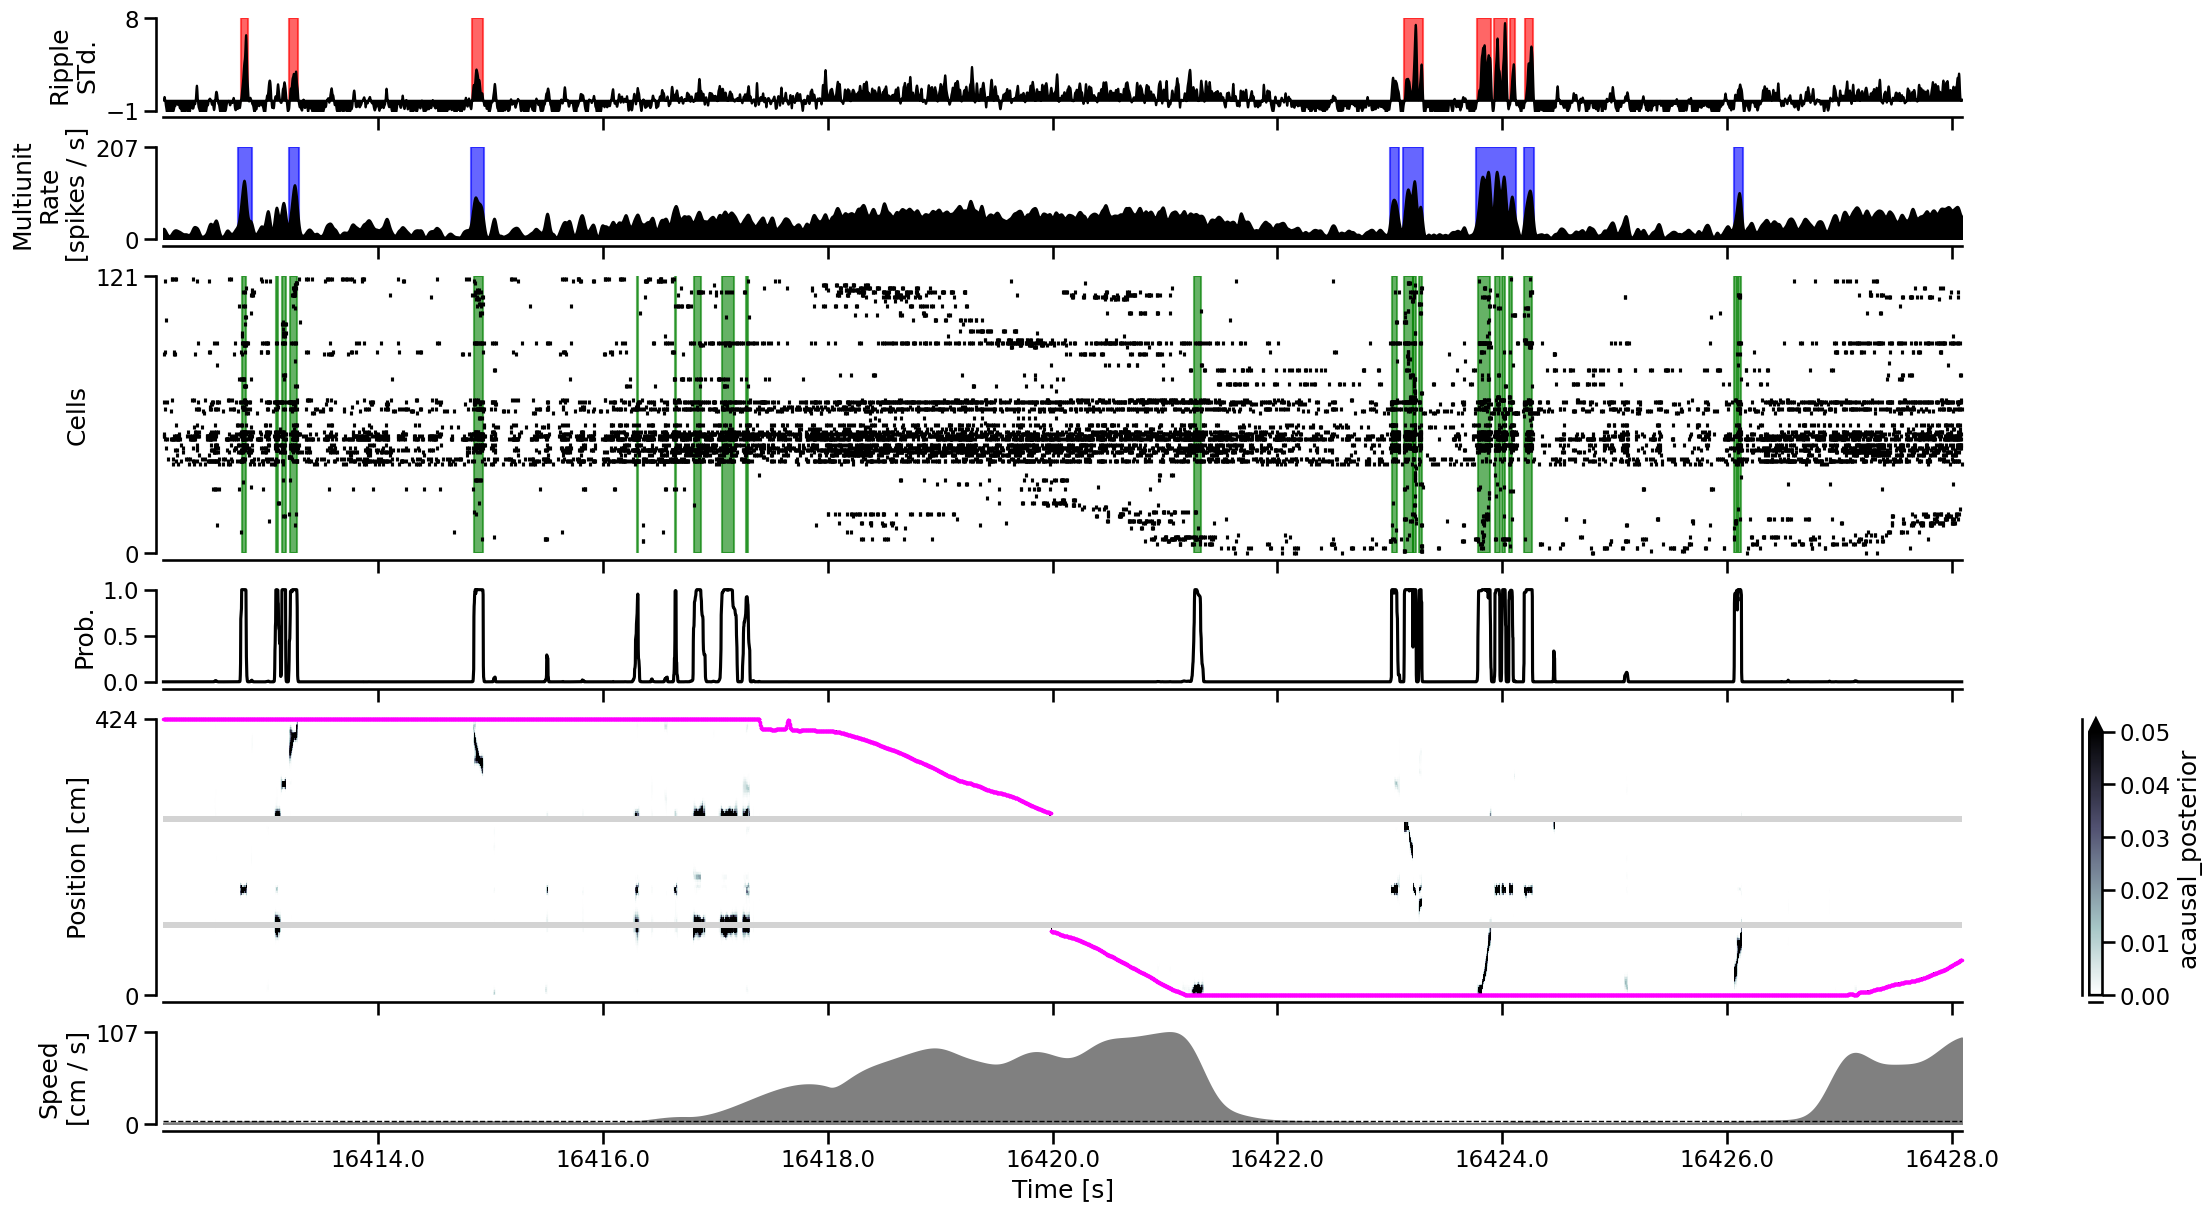

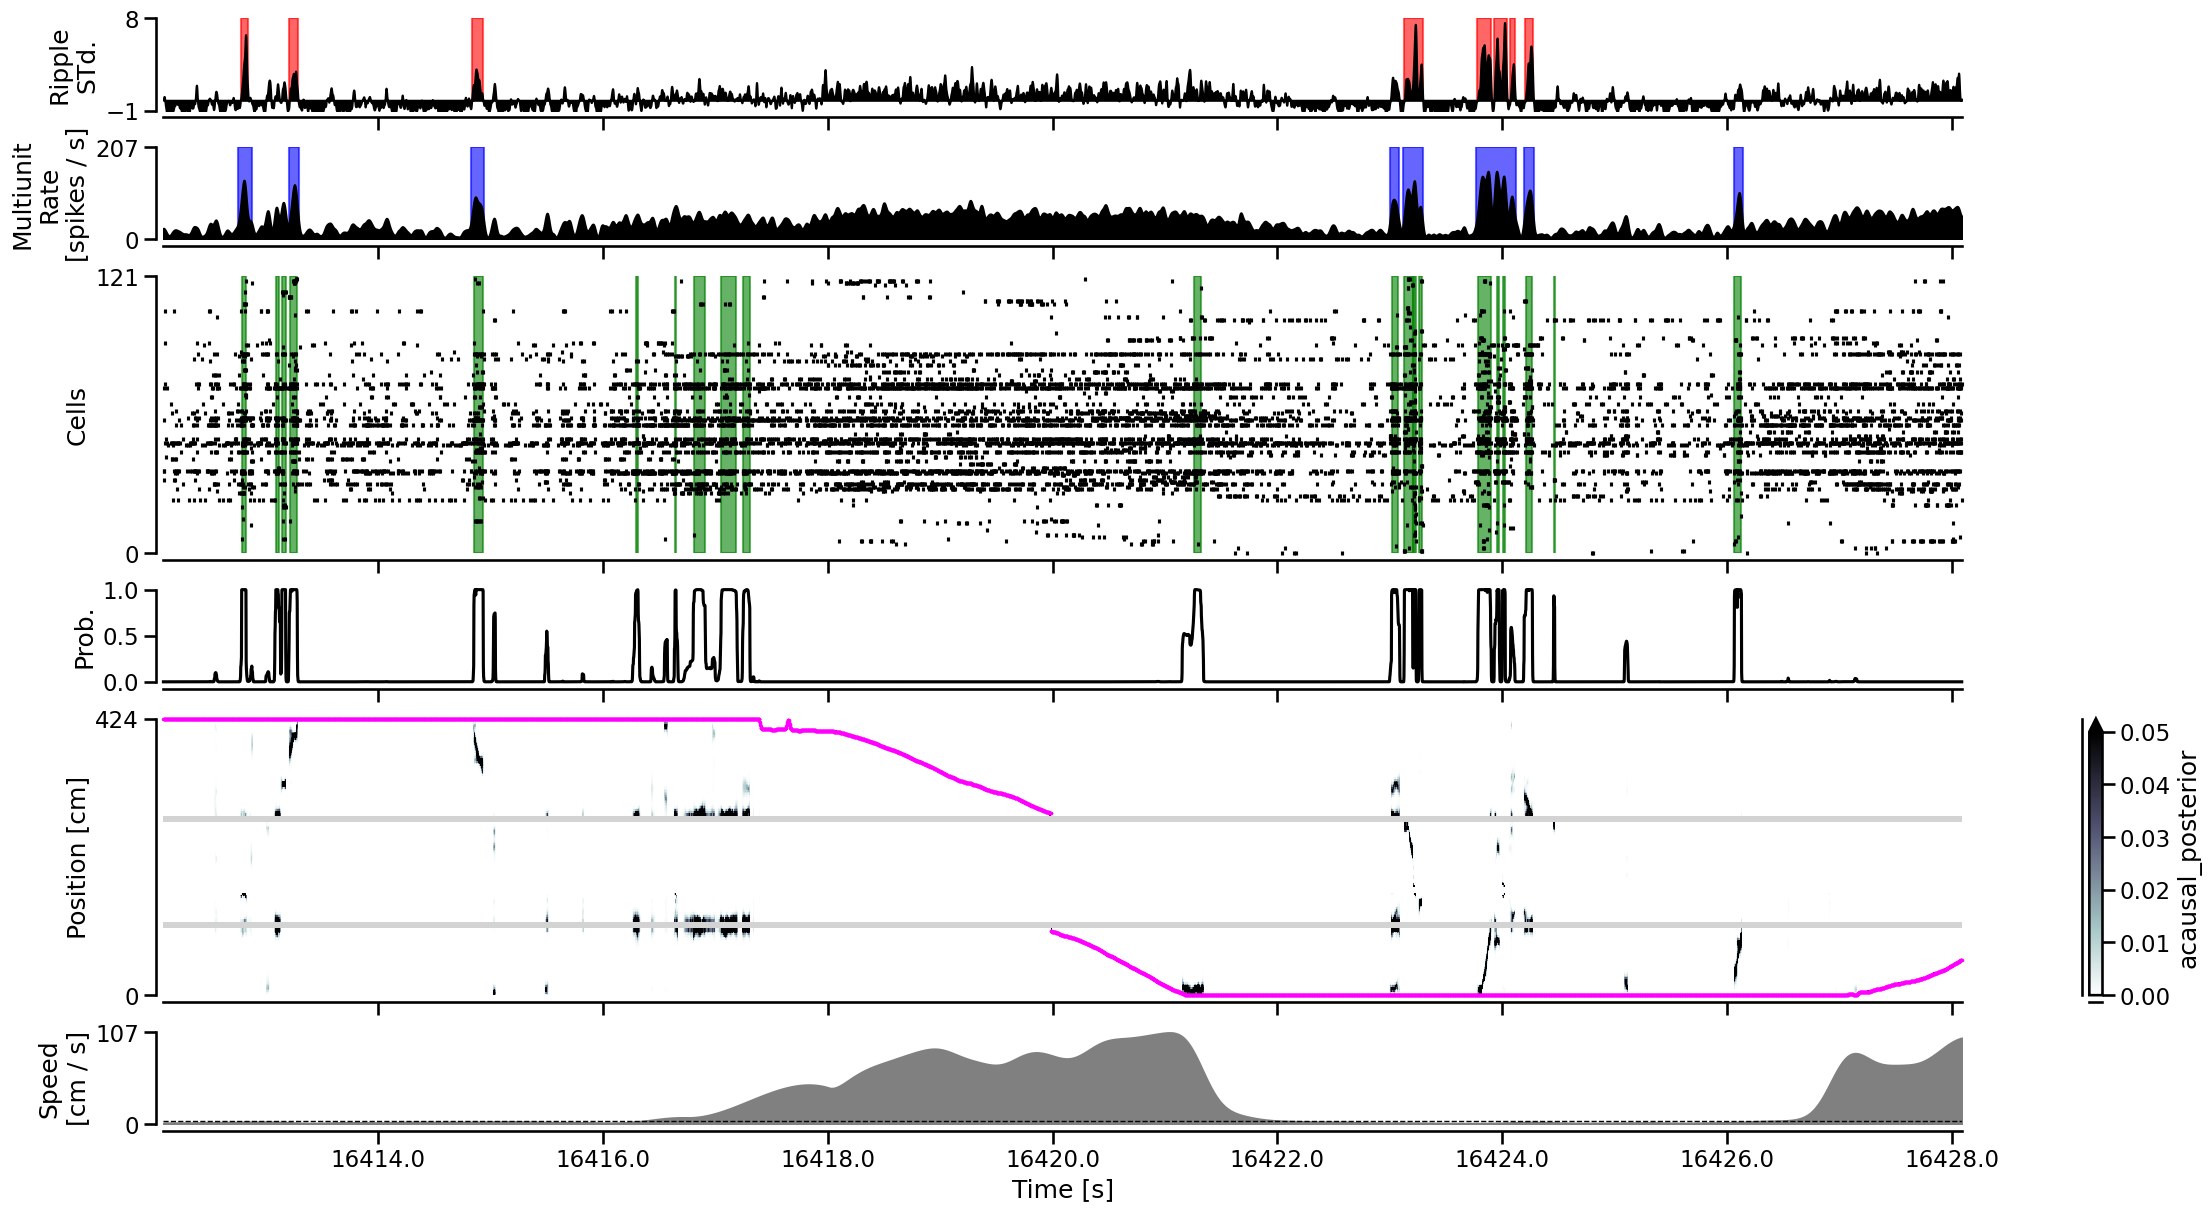

In [258]:
time_slice = slice(22_000, 30_000)
plot_detector(time_slice, data, replay_detector, results, figsize=(22, 12.0))
plot_detector(time_slice, data, replay_detector_likelihood_only, results_likelihood_only, figsize=(22, 12.0))

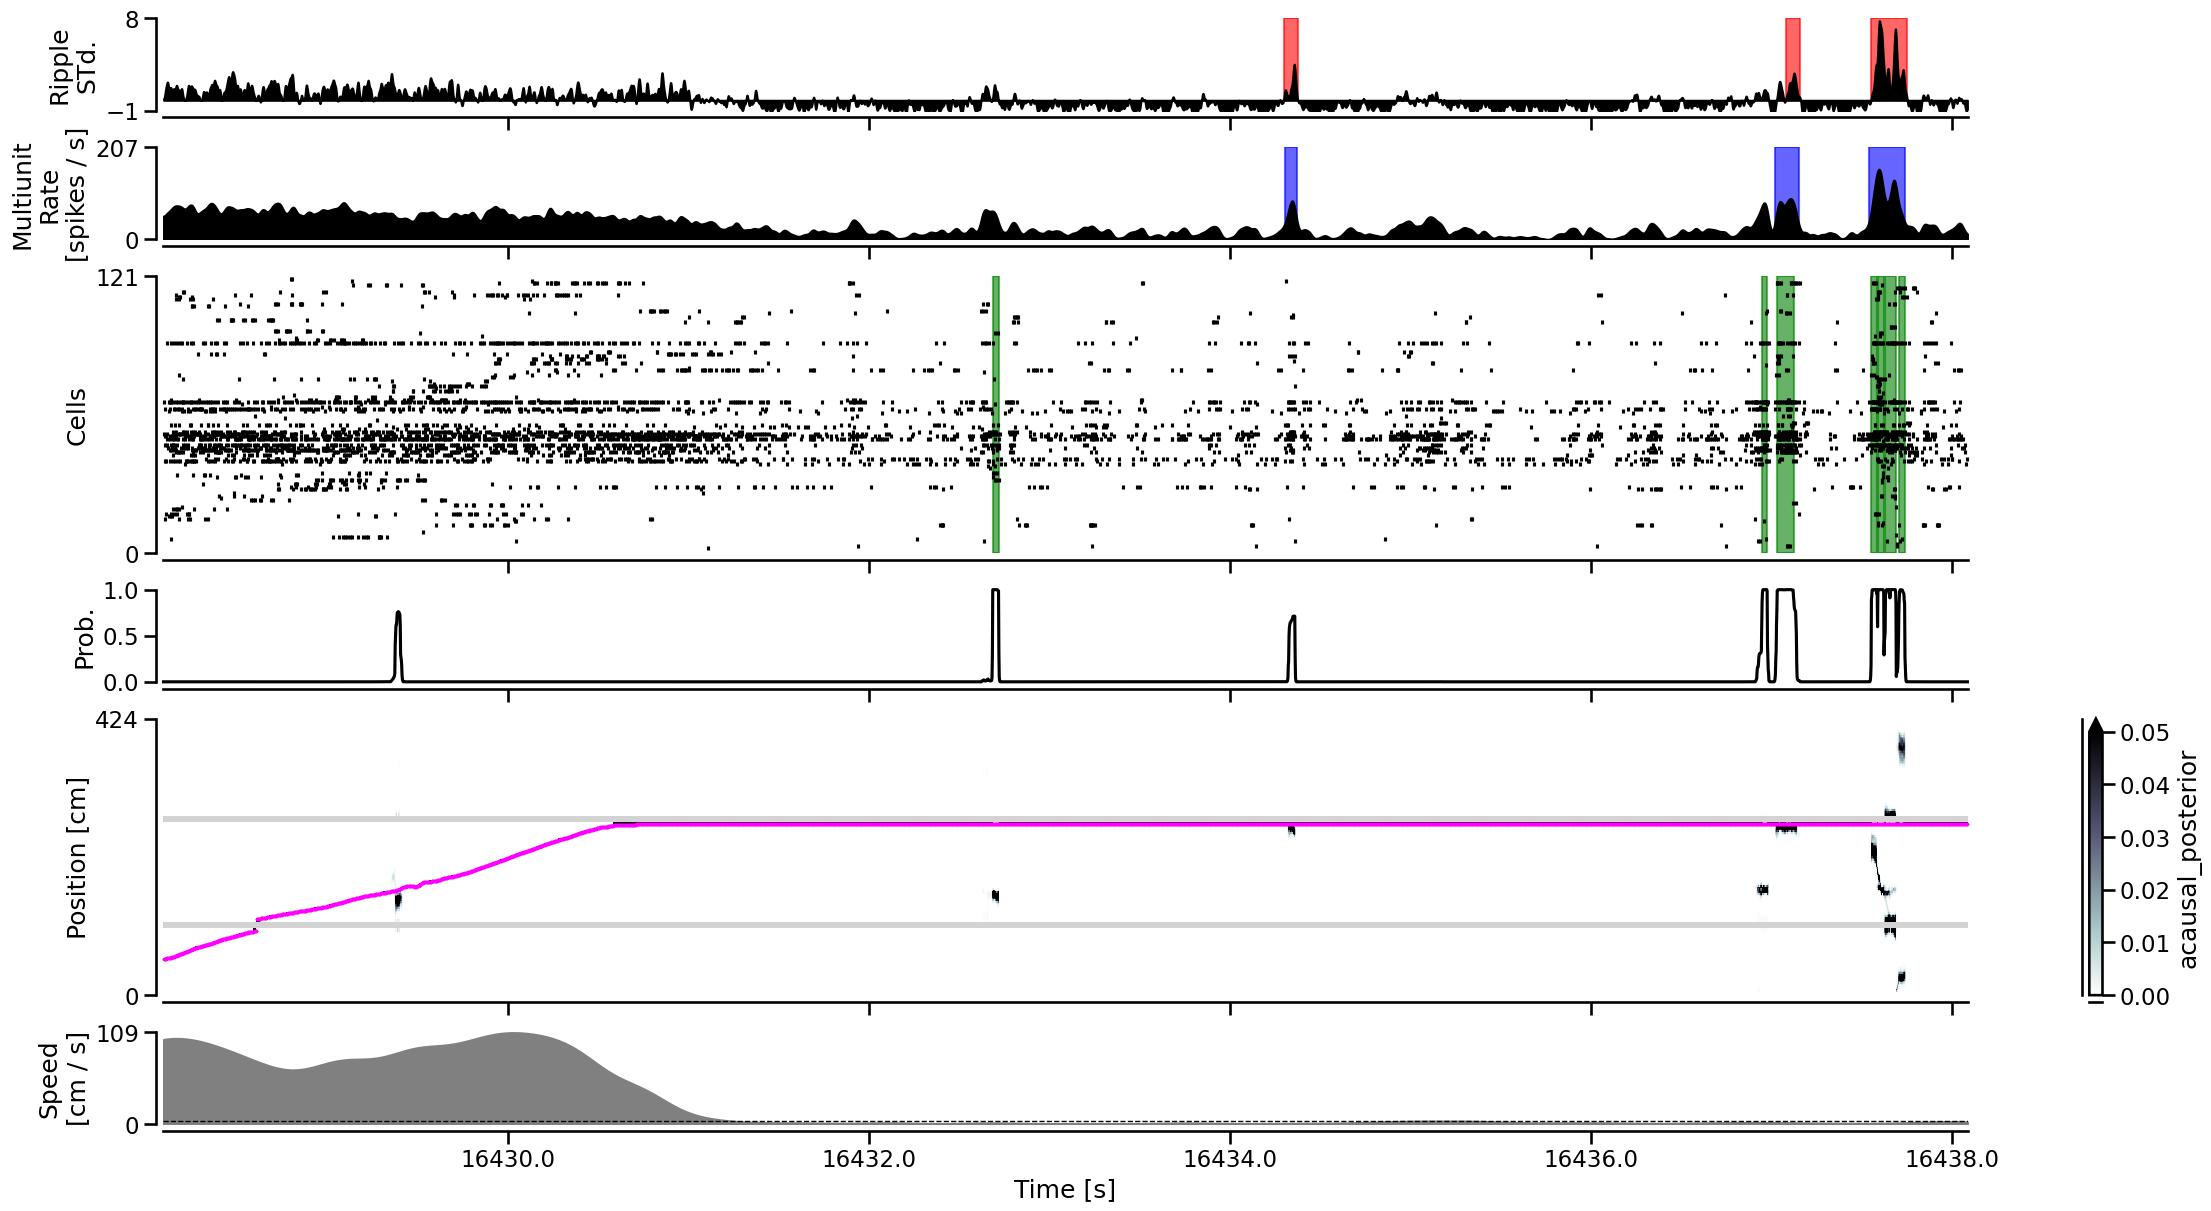

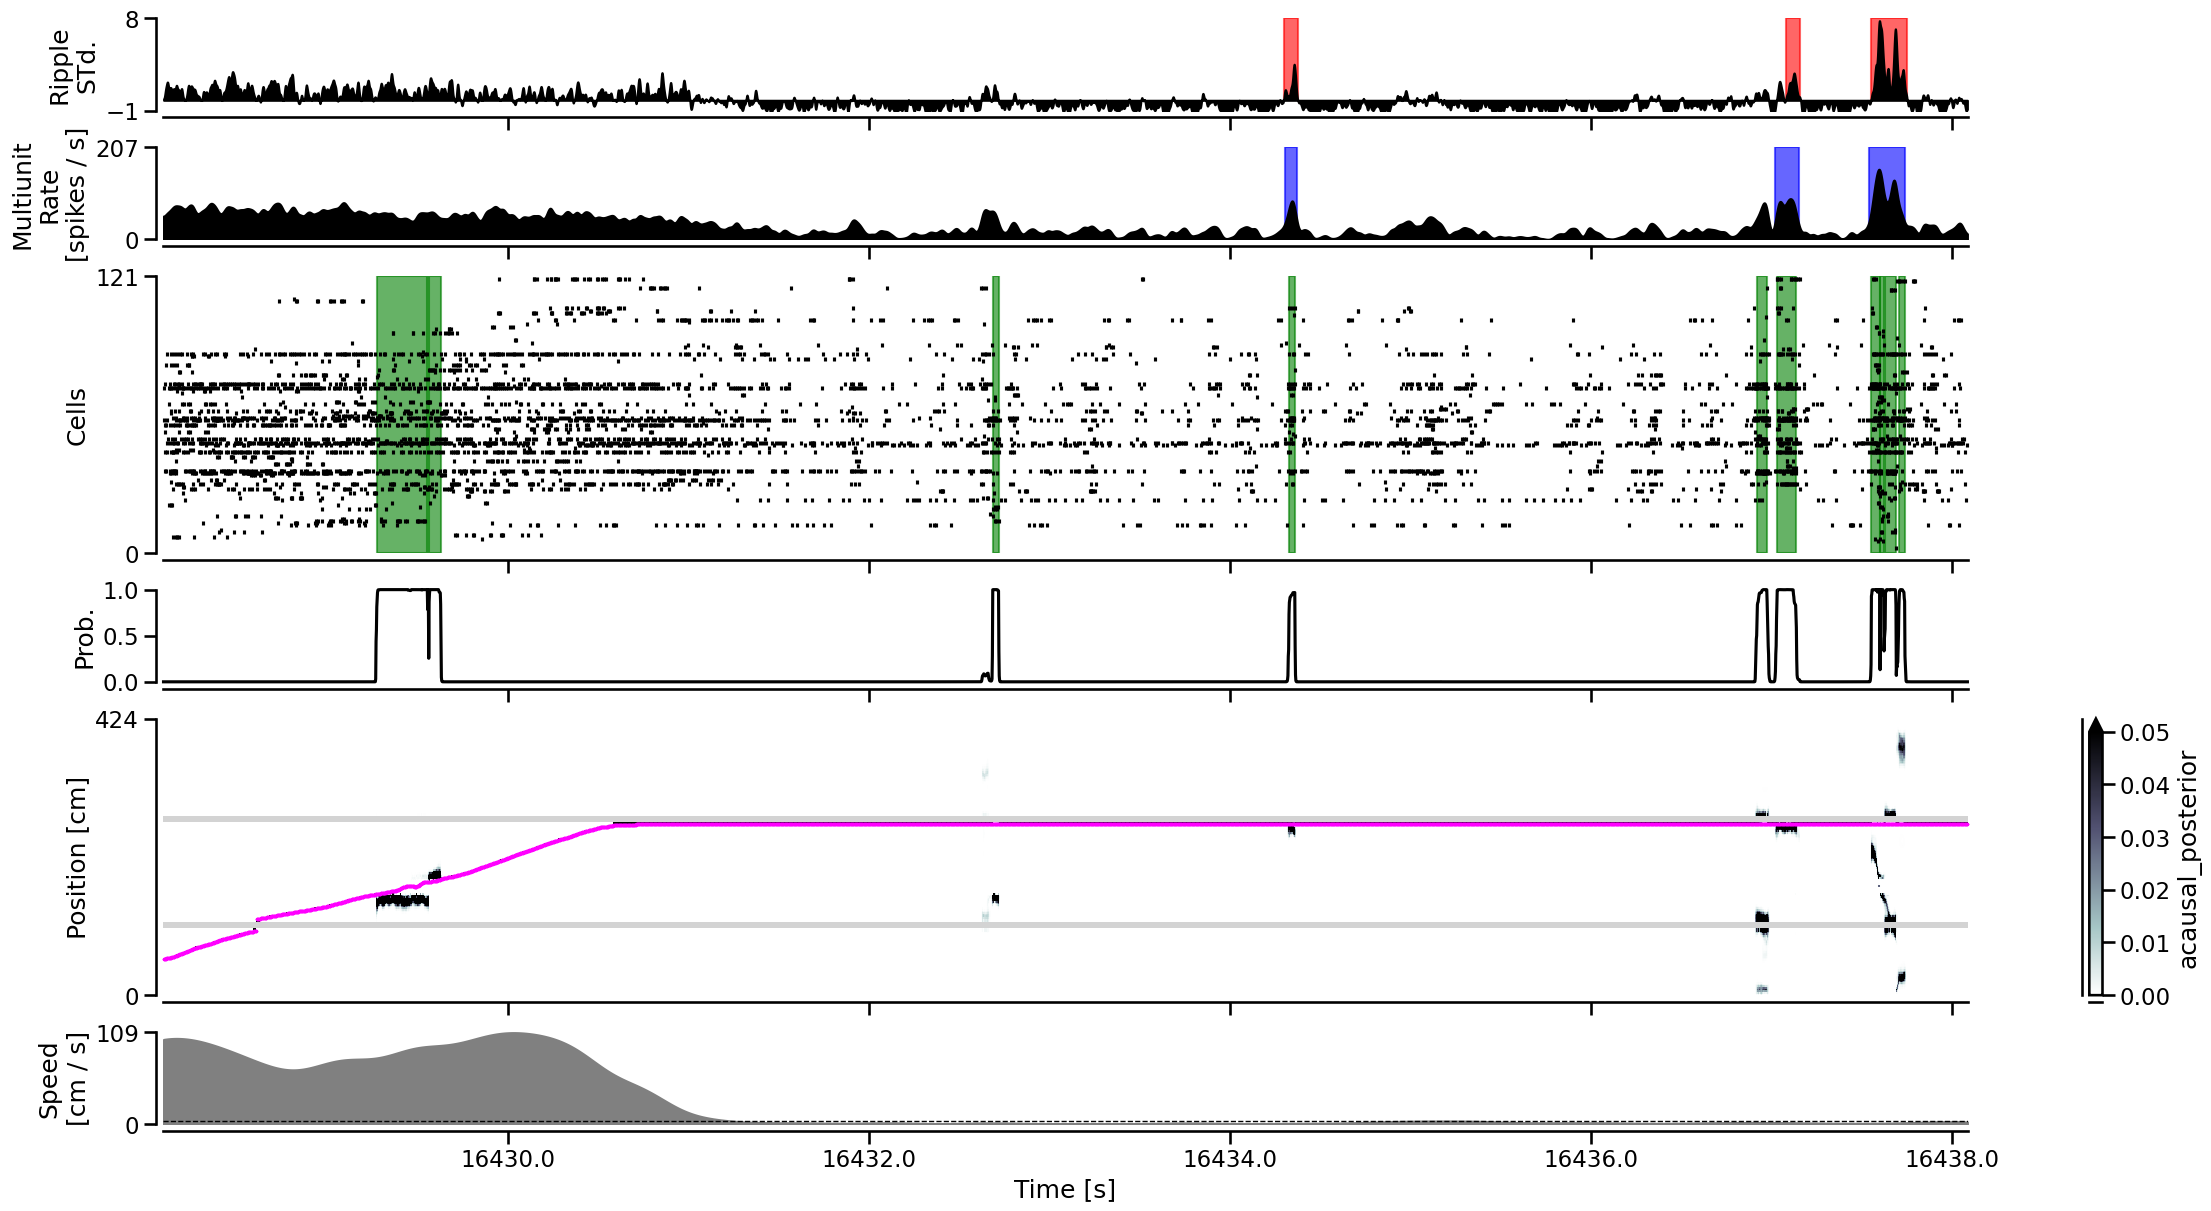

In [259]:
time_slice = slice(30_000, 35_000)
plot_detector(time_slice, data, replay_detector, results, figsize=(22, 12.0))
plot_detector(time_slice, data, replay_detector_likelihood_only, results_likelihood_only, figsize=(22, 12.0))

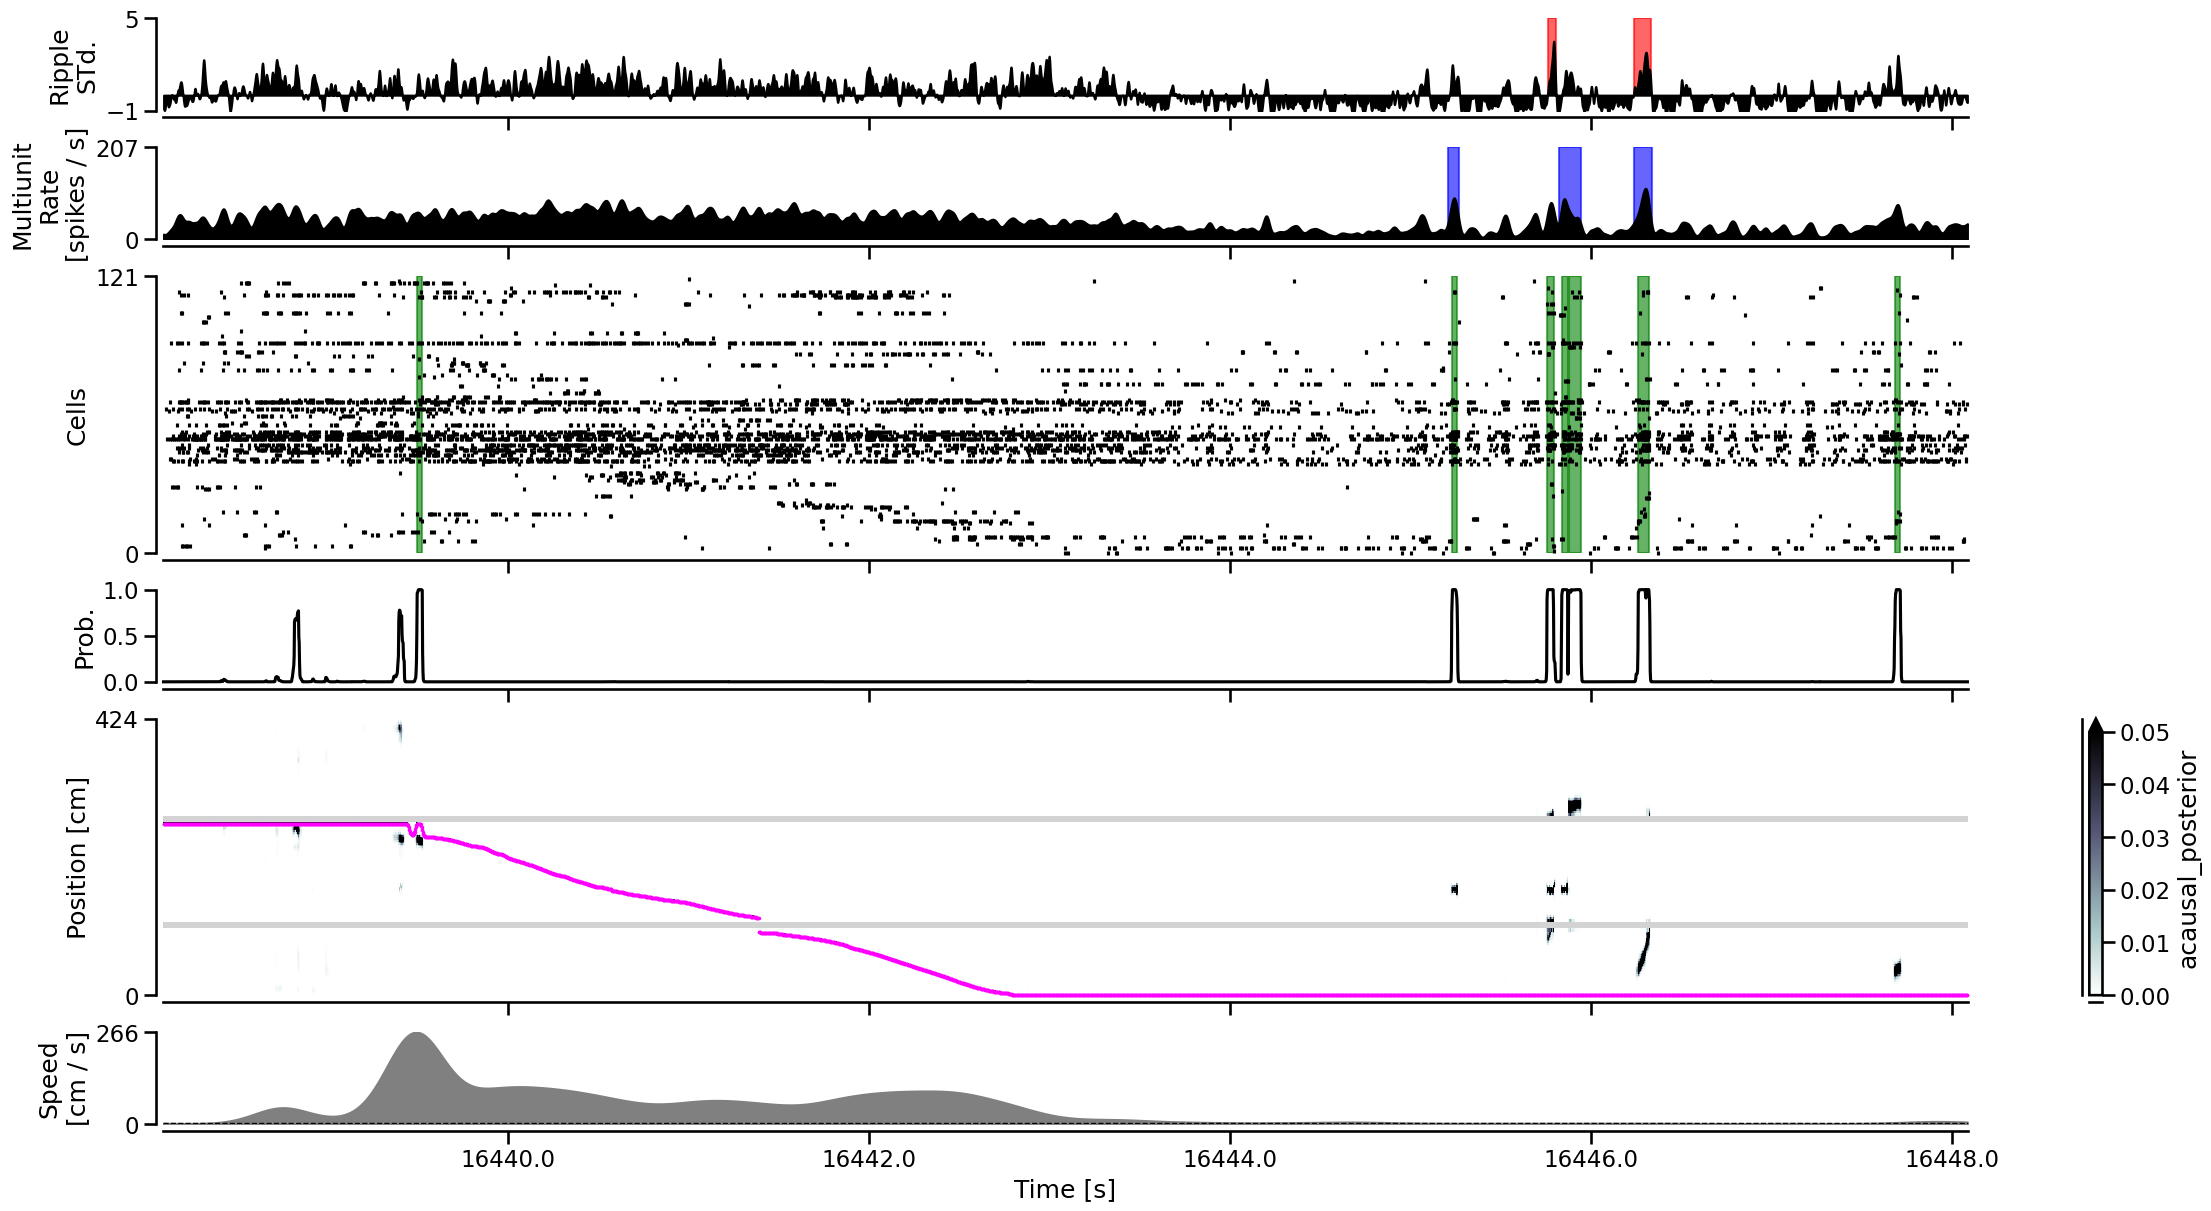

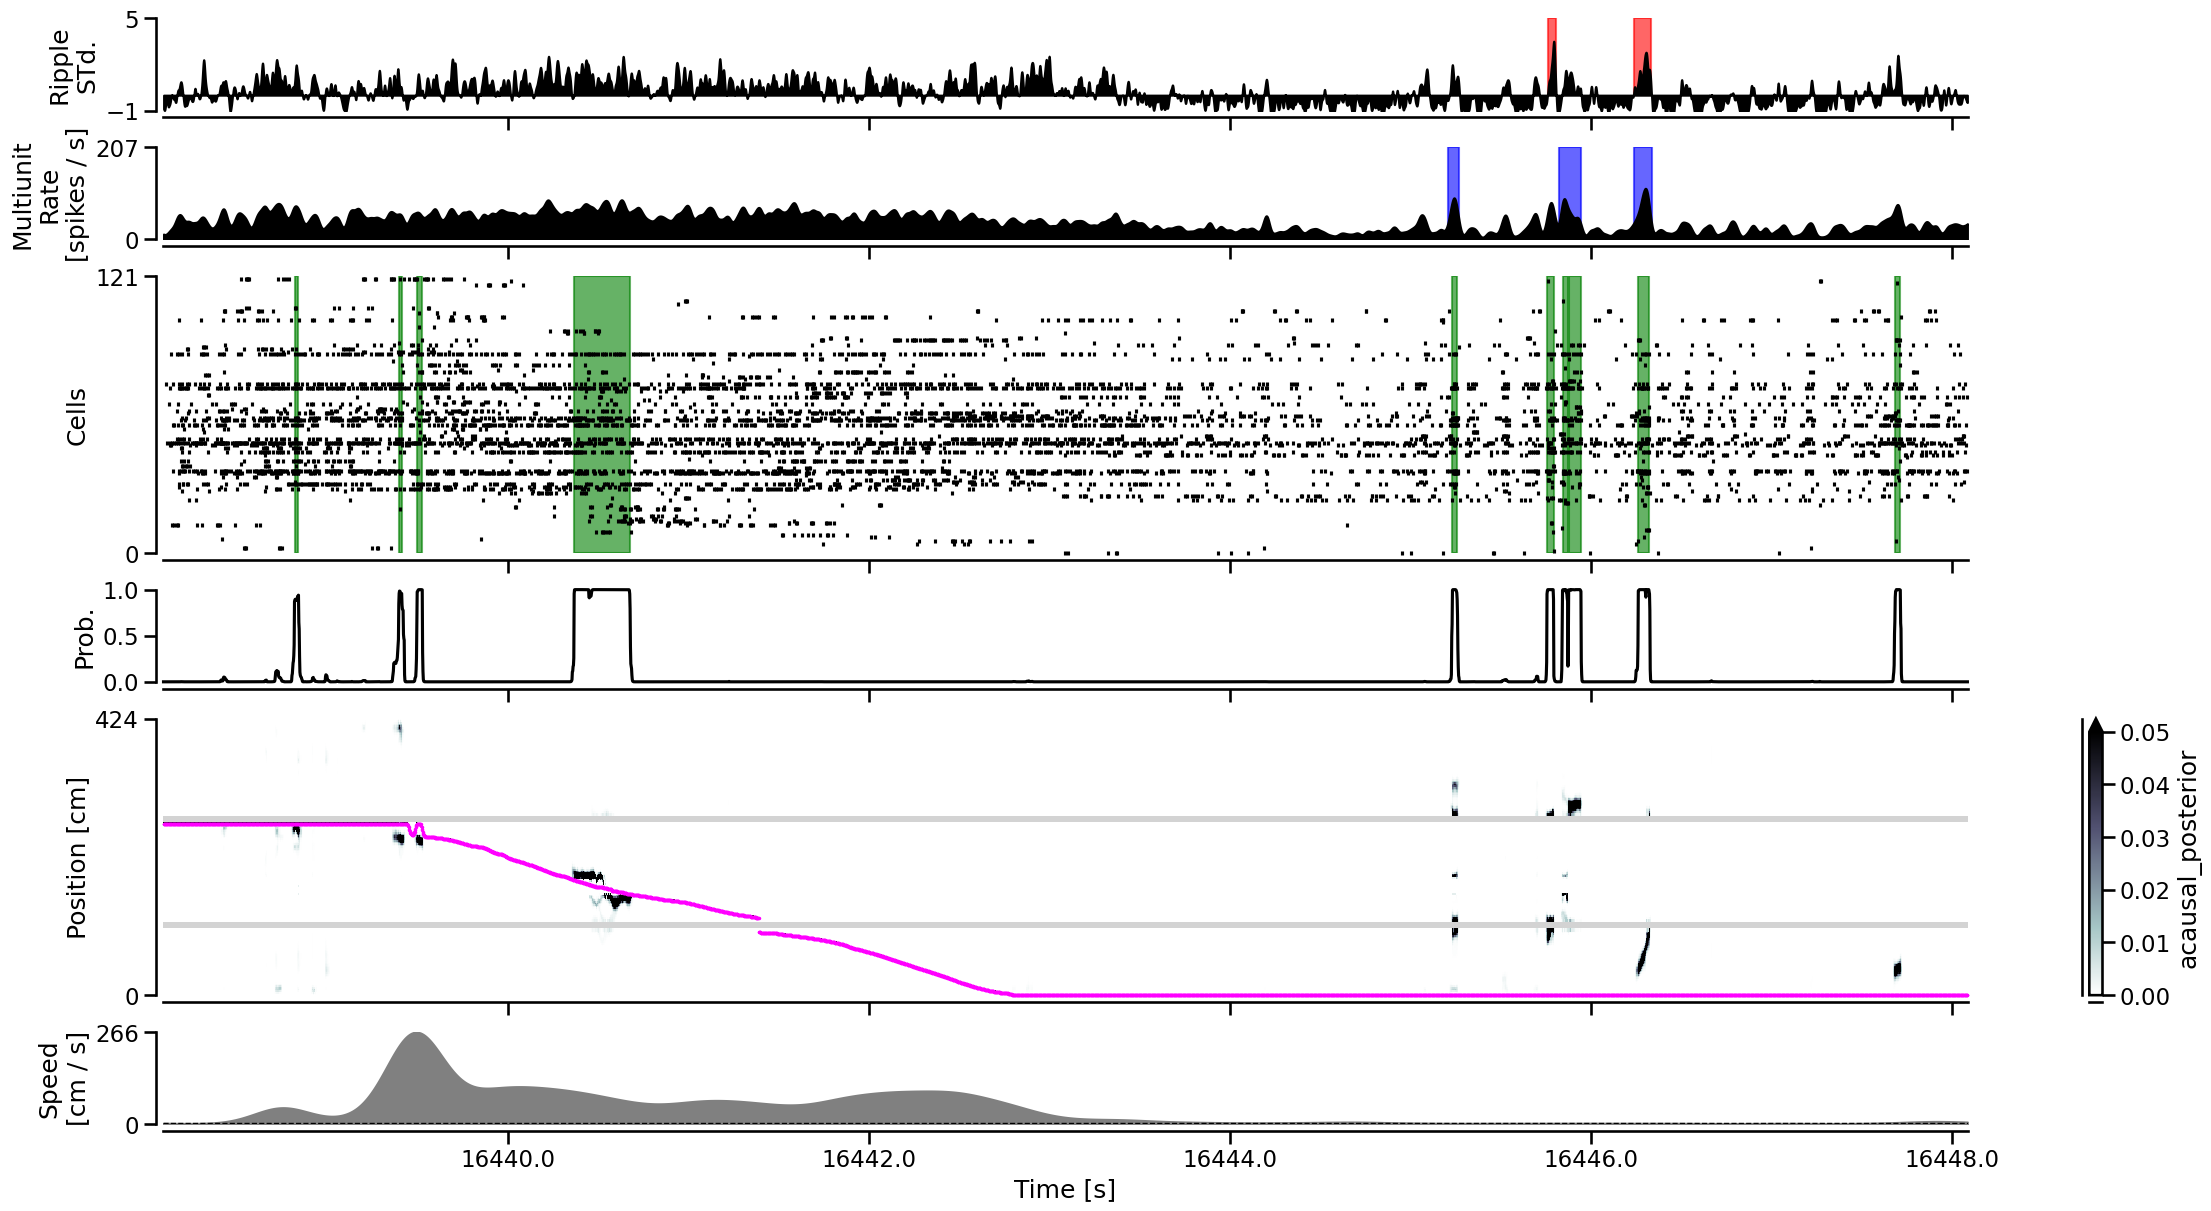

In [260]:
time_slice = slice(35_000, 40_000)
plot_detector(time_slice, data, replay_detector, results, figsize=(22, 12.0))
plot_detector(time_slice, data, replay_detector_likelihood_only, results_likelihood_only, figsize=(22, 12.0))

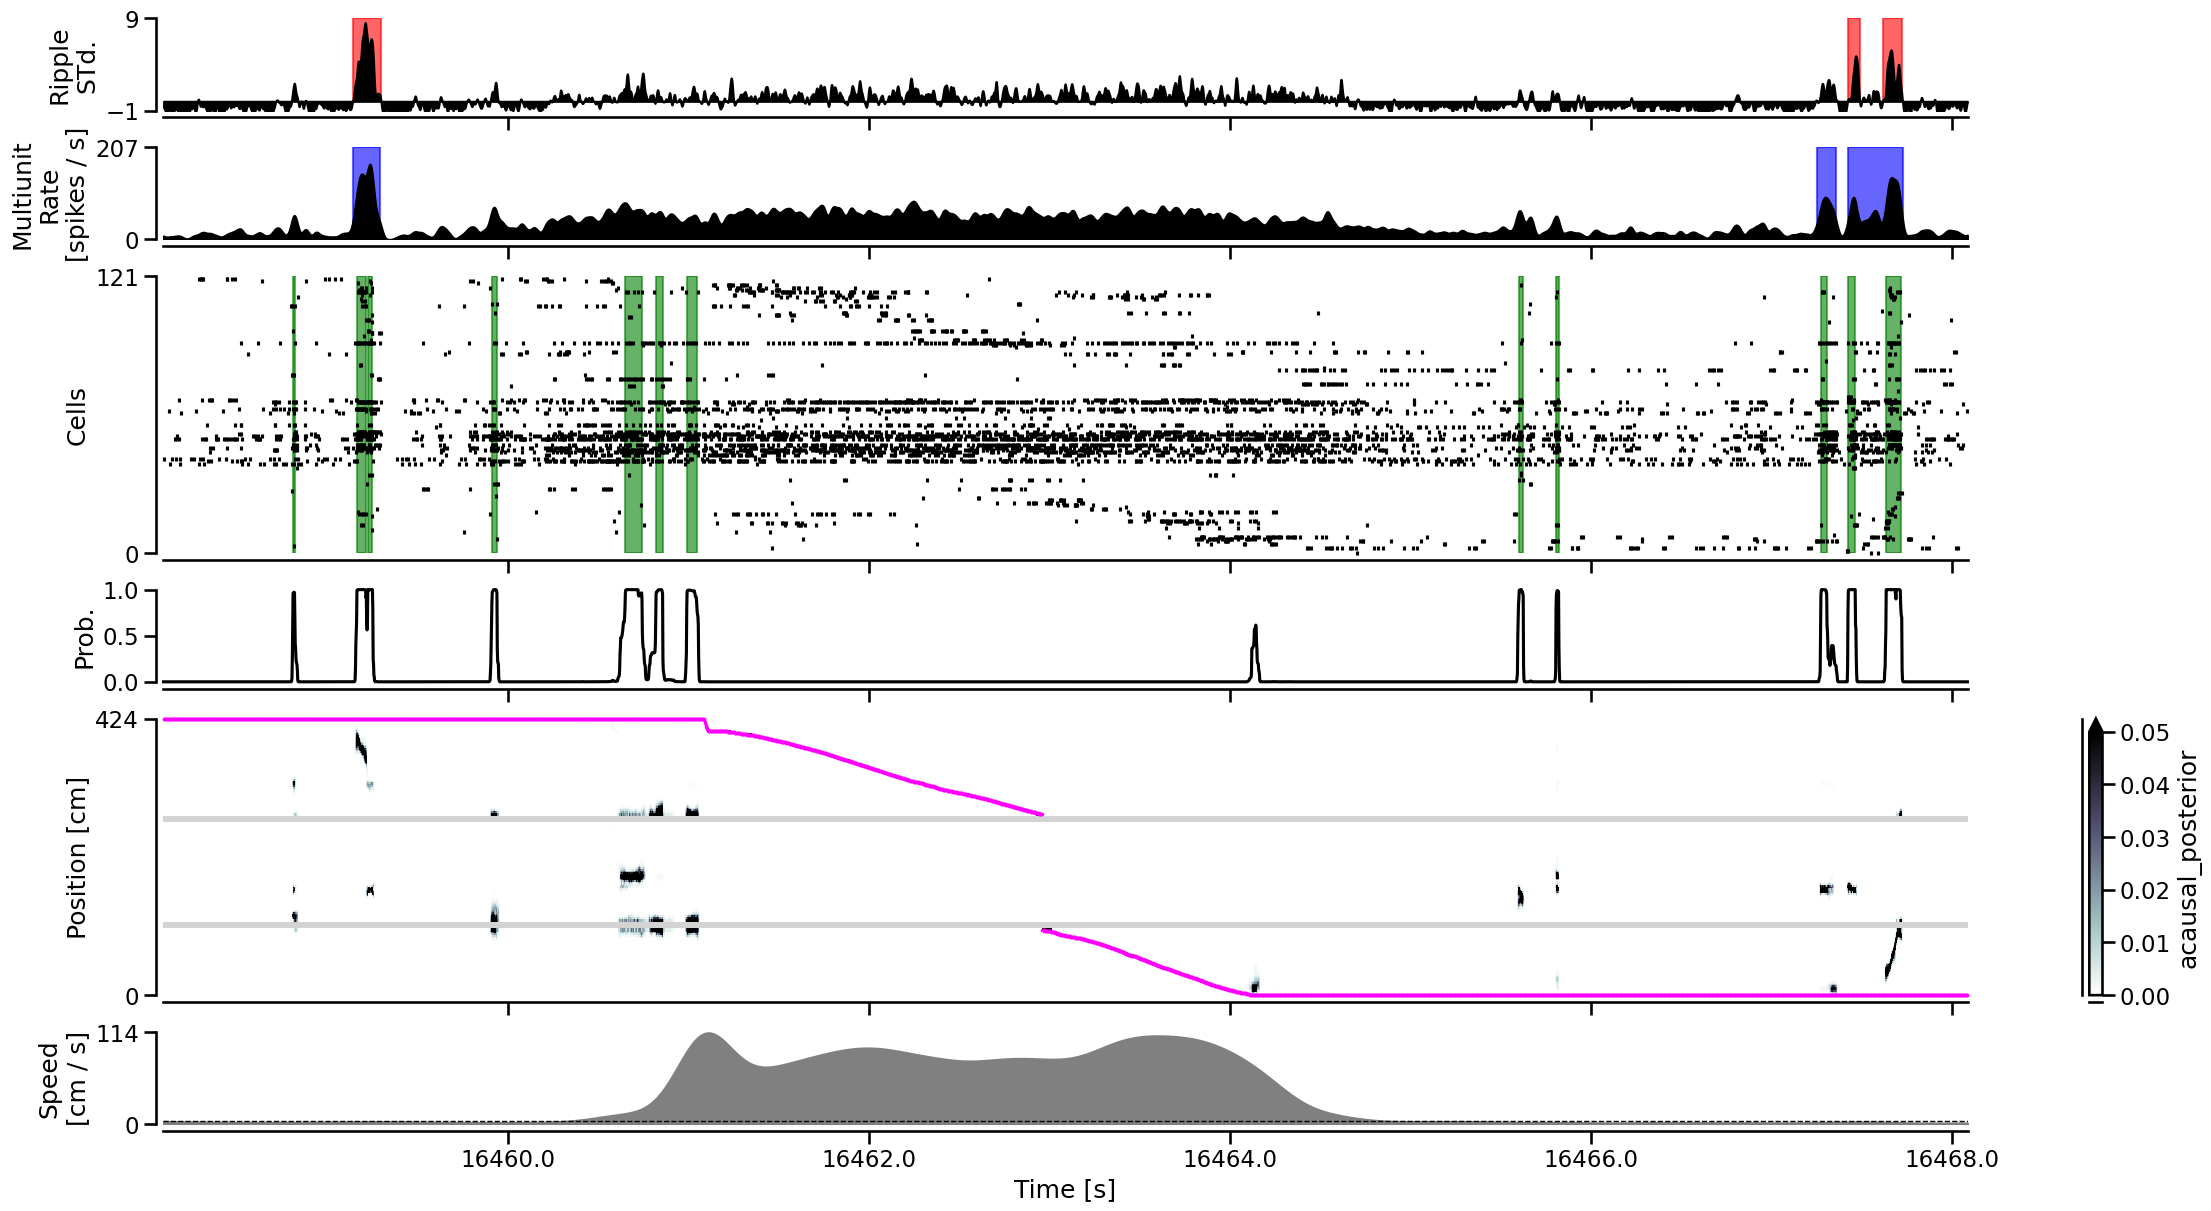

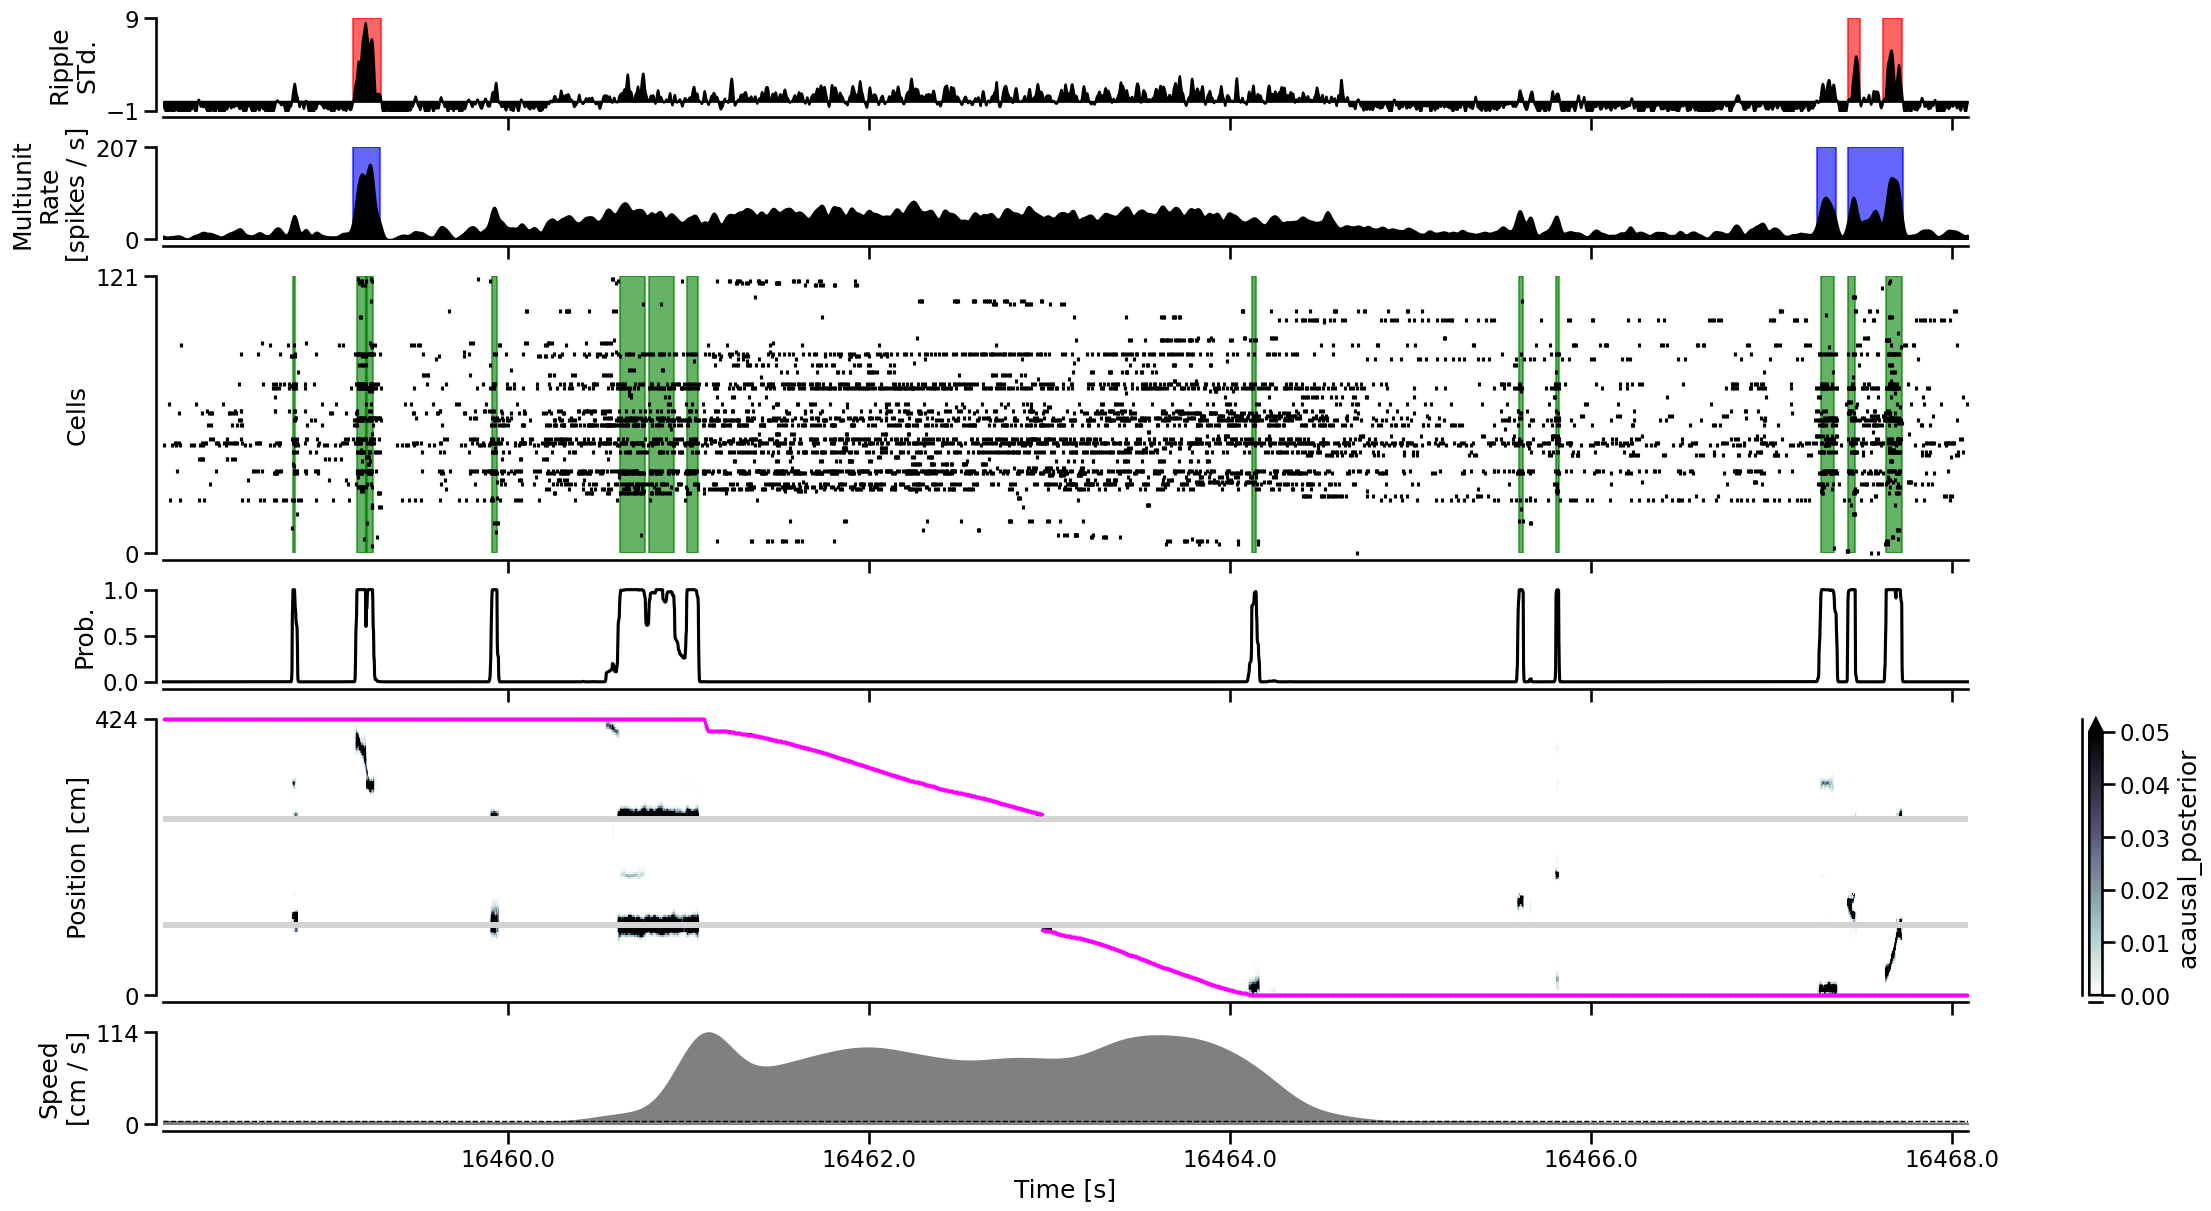

In [262]:
time_slice = slice(45_000, 50_000)
plot_detector(time_slice, data, replay_detector, results, figsize=(22, 12.0))
plot_detector(time_slice, data, replay_detector_likelihood_only, results_likelihood_only, figsize=(22, 12.0))

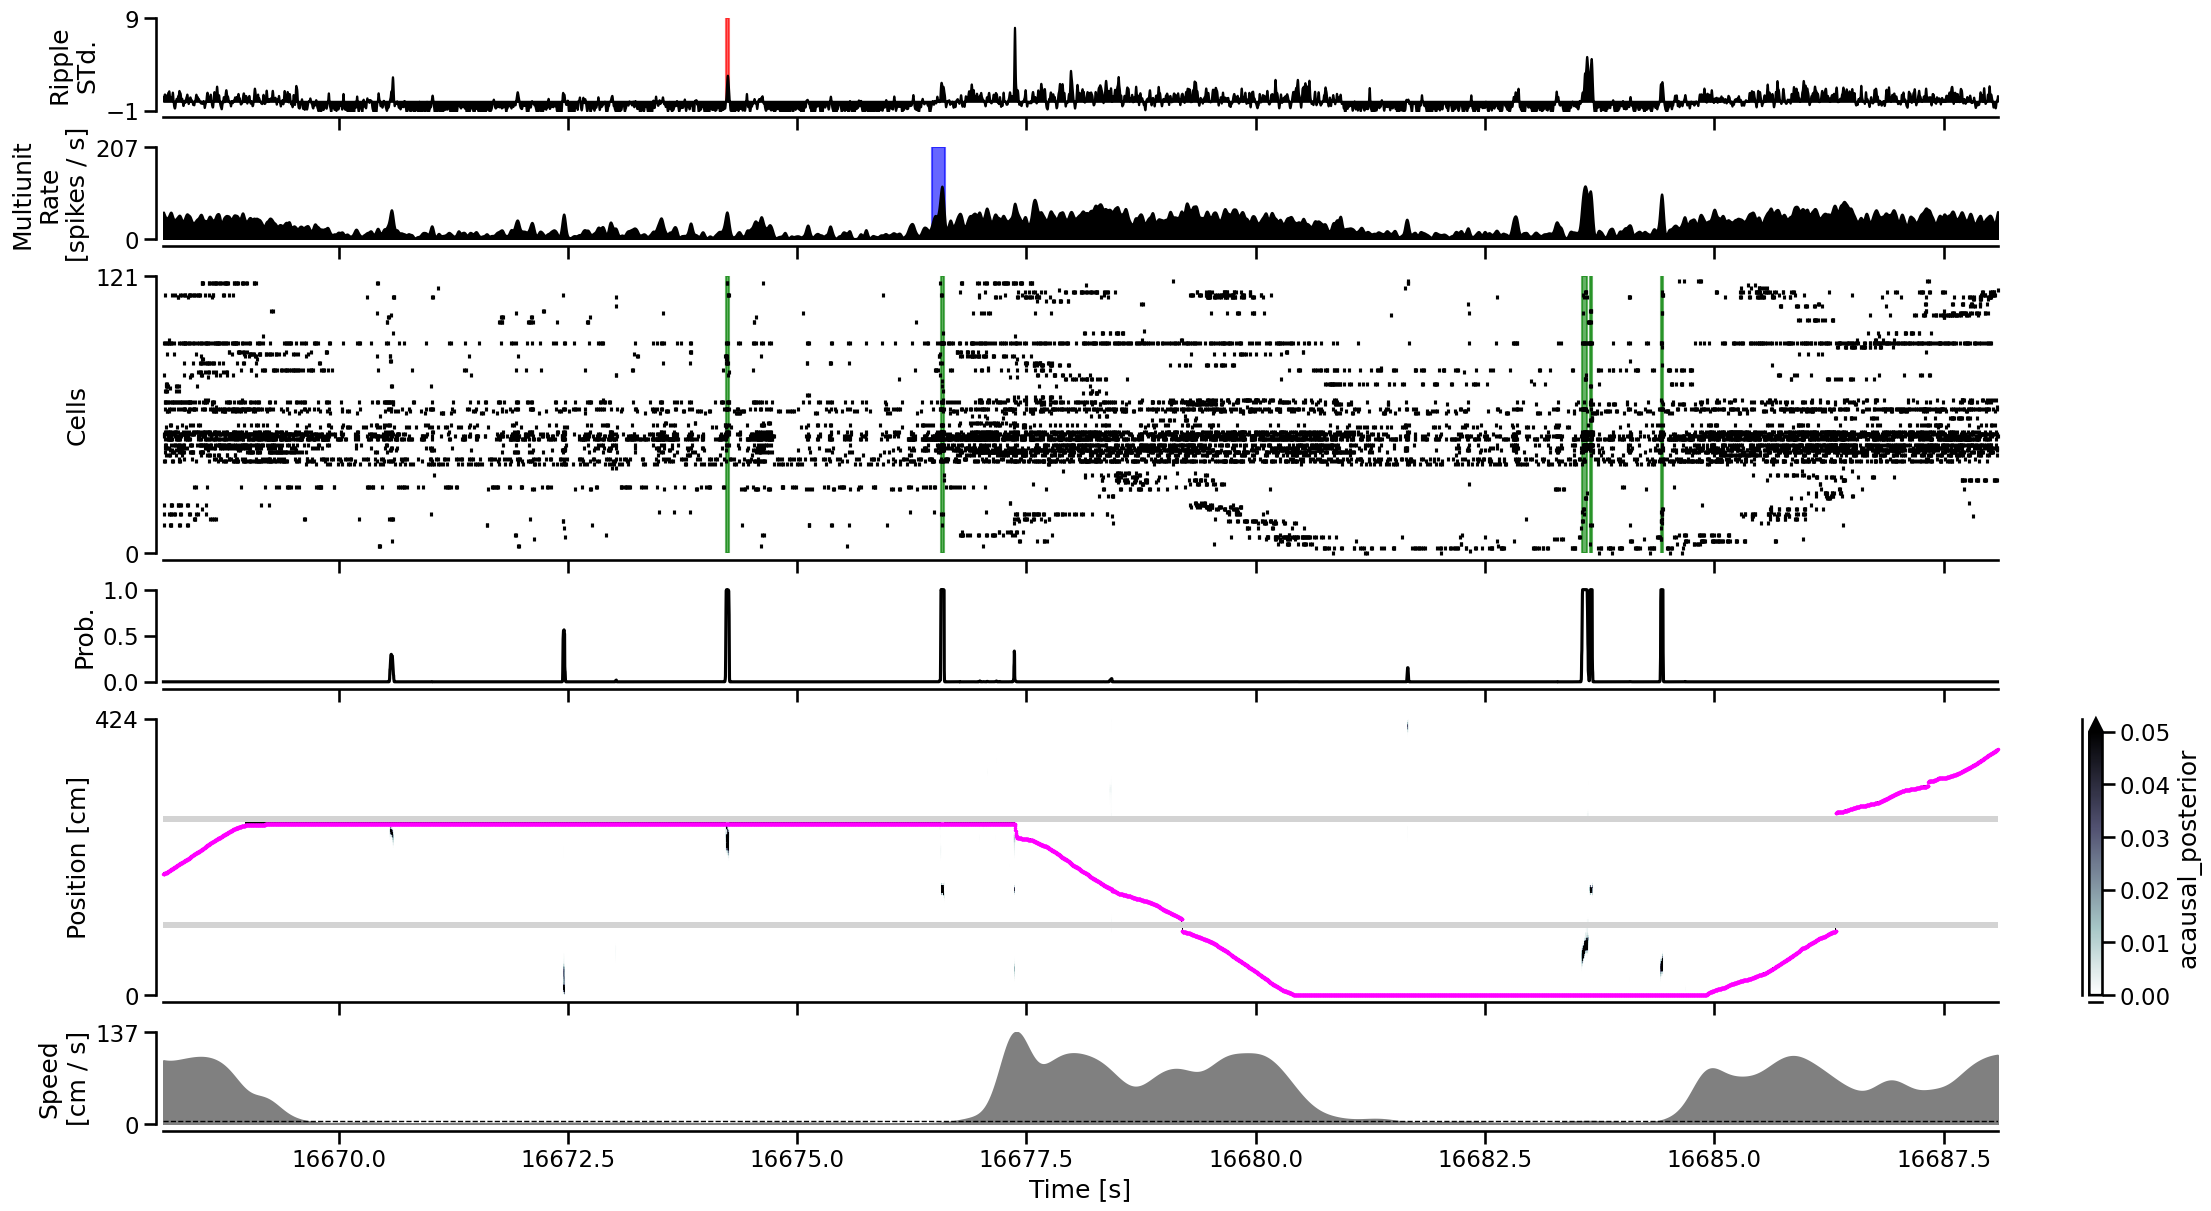

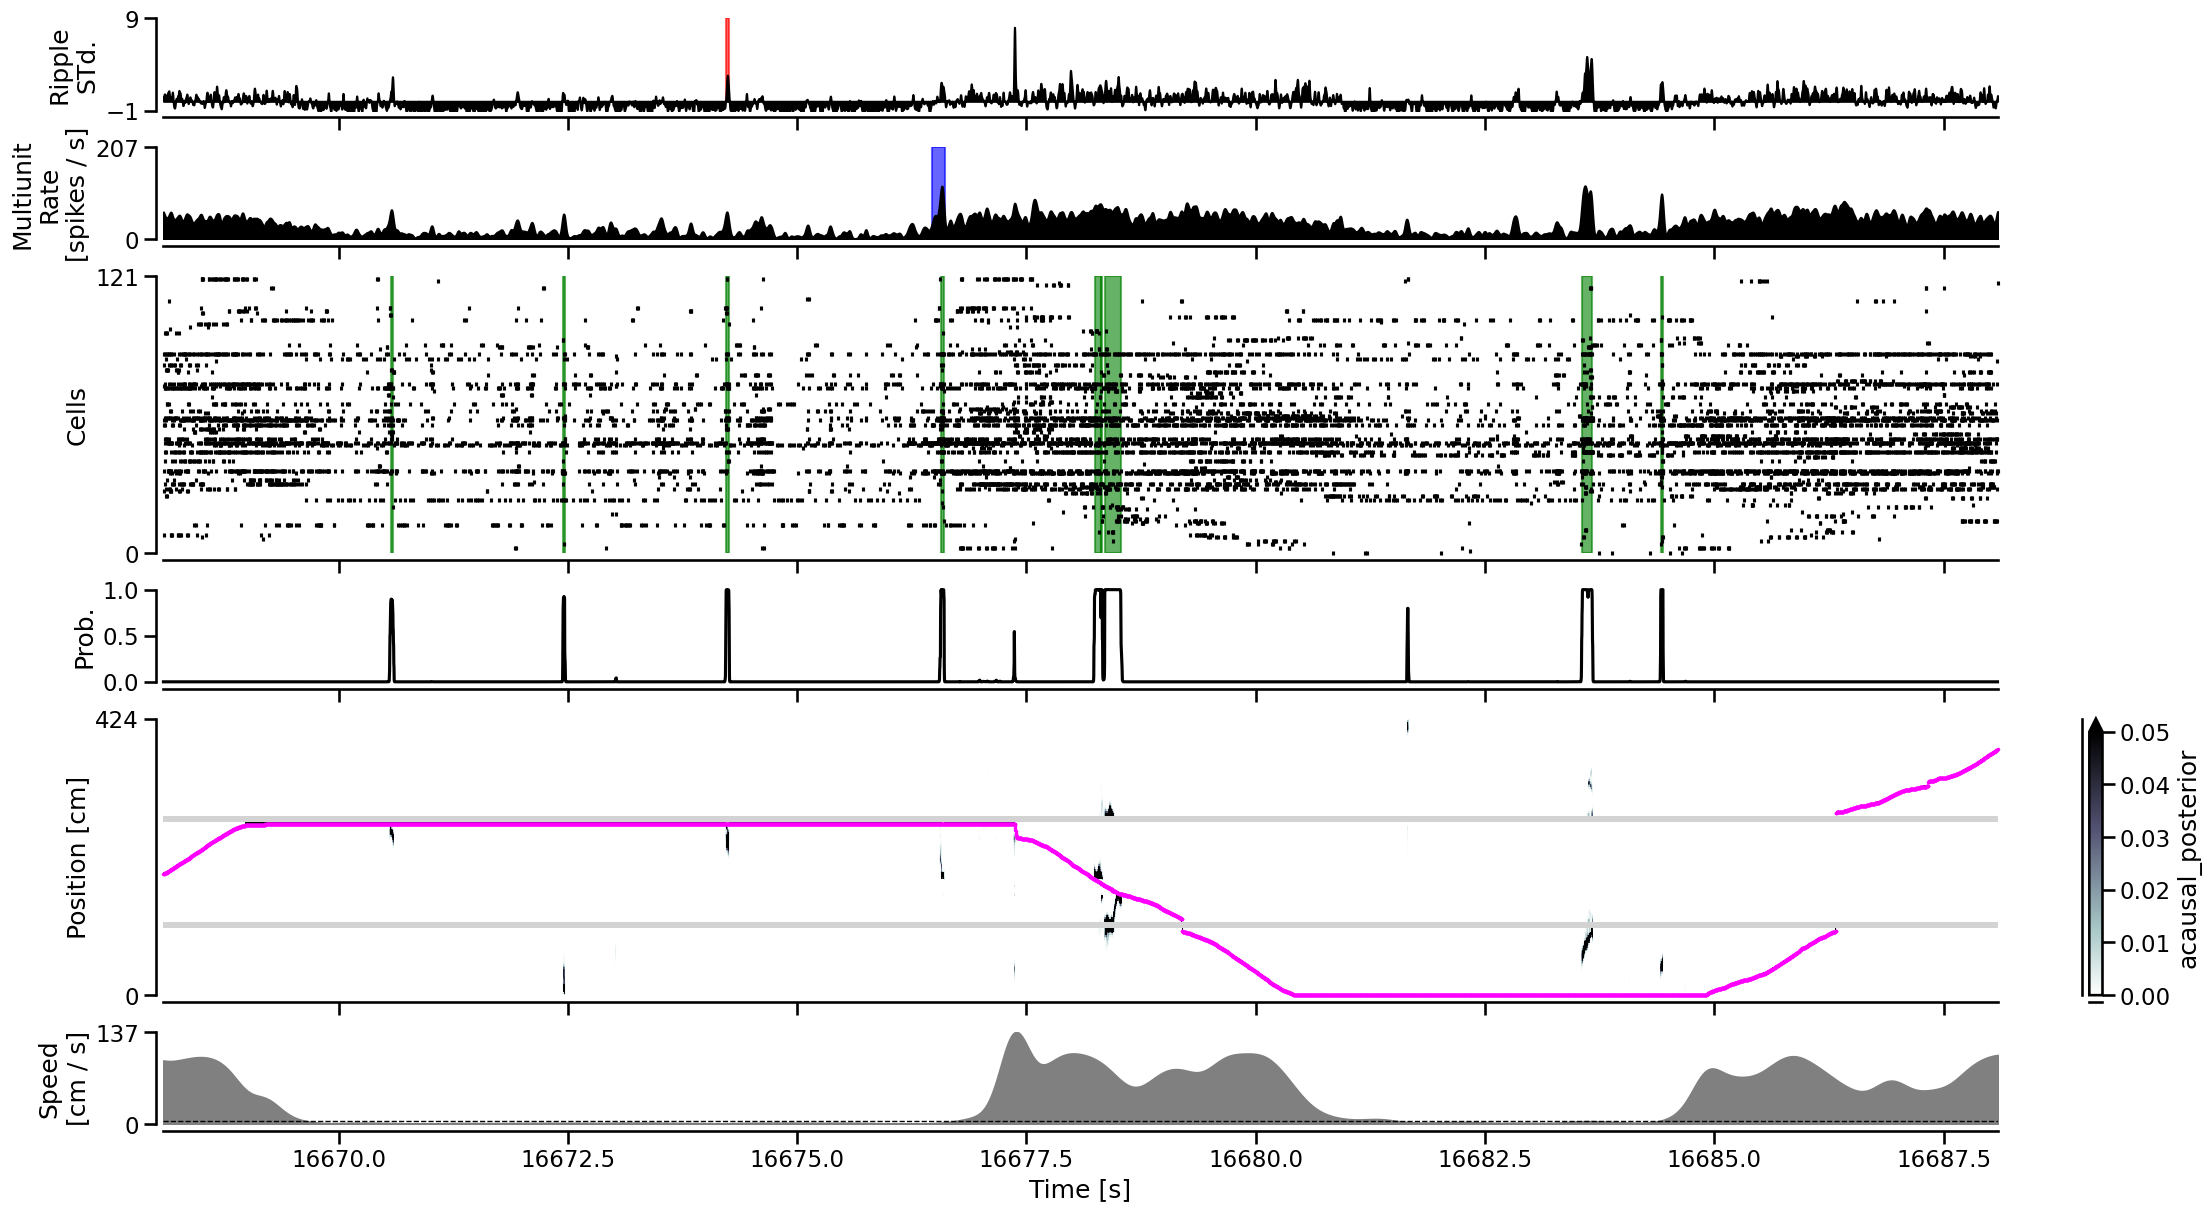

In [263]:
time_slice = slice(150_000, 160_000)
plot_detector(time_slice, data, replay_detector, results, figsize=(22, 12.0))
plot_detector(time_slice, data, replay_detector_likelihood_only, results_likelihood_only, figsize=(22, 12.0))

In [267]:
results.position

<xarray.DataArray 'position' (position: 161)>
array([  1.249152,   3.747456,   6.245759,   8.744063,  11.242367,  13.740671,
        16.238975,  18.737278,  21.235582,  23.733886,  26.23219 ,  28.730494,
        31.228797,  33.727101,  36.225405,  38.723709,  41.222013,  43.720316,
        46.21862 ,  48.716924,  51.215228,  53.713531,  56.211835,  58.710139,
        61.208443,  63.706747,  66.20505 ,  68.703354,  71.201658,  73.699962,
        76.198266,  78.696569,  81.194873,  83.693177,  86.191481,  88.689784,
        91.188088,  93.686392,  96.184696,  98.683   , 107.432152, 116.156233,
       118.604397, 121.05256 , 123.500724, 125.948887, 128.397051, 130.845214,
       133.293378, 135.741541, 138.189705, 140.637868, 143.086032, 145.534195,
       147.982359, 150.430522, 152.878686, 155.326849, 157.775012, 160.223176,
       162.679103, 165.142794, 167.606485, 170.070175, 172.533866, 174.997557,
       177.461247, 179.924938, 182.388629, 184.85232 , 187.31601 , 189.779701,
       192.243392, 194.707082, 197.170773, 199.634464, 202.098155, 204.561845,
       207.025536, 209.489227, 211.952917, 214.416608, 216.880299, 219.34399 ,
       221.80768 , 224.271371, 226.735062, 229.198752, 231.662443, 234.126134,
       236.589825, 239.053515, 241.517206, 243.980897, 246.444587, 248.908278,
       251.371969, 253.83566 , 256.29935 , 258.763041, 261.226732, 269.958577,
       278.680151, 281.123298, 283.566446, 286.009593, 288.452741, 290.895888,
       293.339035, 295.782183, 298.22533 , 300.668478, 303.111625, 305.554773,
       307.99792 , 310.441068, 312.884215, 315.327362, 317.77051 , 320.213657,
       322.656805, 325.125559, 327.619921, 330.114283, 332.608644, 335.103006,
       337.597368, 340.091729, 342.586091, 345.080453, 347.574814, 350.069176,
       352.563538, 355.057899, 357.552261, 360.046623, 362.540984, 365.035346,
       367.529708, 370.024069, 372.518431, 375.012793, 377.507154, 380.001516,
       382.495878, 384.990239, 387.484601, 389.978963, 392.473324, 394.967686,
       397.462048, 399.95641 , 402.450771, 404.945133, 407.439495, 409.933856,
       412.428218, 414.92258 , 417.416941, 419.911303, 422.405665])
Coordinates:
  * position  (position) float64 1.249 3.747 6.246 8.744 ... 417.4 419.9 422.4